# Million Song Dataset

# Aufgabe 1: Feature - Vektor

Das Subsample des Million Song Dataset ist eine umfangreiche, frei verfügbare Sammlung von Metadaten und Audio-Features zu über einer Million zeitgenössischer Musiktitel. Ziel des Datensatzes ist es, Forschung und Entwicklung in den Bereichen Music Information Retrieval (MIR), Empfehlungssysteme und Musikdatenanalyse zu unterstützen.  
Der Datensatz enthält **keine Audiodateien**, sondern strukturierte Informationen, die in **vier klar definierte Segmente** gegliedert sind.

## 1. Metadata (Basis-Metadaten)
Beschreibt allgemeine, titelbezogene Informationen.

- `track_id` — *string*  
- `song_id` — *string*  
- `title` — *string*  
- `artist_name` — *string*  
- `artist_id` — *string*  
- `artist_hotttnesss` — *float*  
- `song_hotttnesss` — *float*  
- `year` — *int*  
- `release` — *string*  
- `duration` — *float* (Sekunden)

## 2. Analysis (Audioanalyse / Low- & Mid-Level-Features)
Automatisch extrahierte musikalische Eigenschaften, primär aus Echo-Nest-Analysen.

- `tempo` — *float* (BPM)  
- `loudness` — *float* (dB)  
- `key` — *int* (0–11)  
- `mode` — *int* (0 = Moll, 1 = Dur)  
- `time_signature` — *int*  
- `danceability` — *float*  
- `energy` — *float*  
- `segments_start` — *array<float>*  
- `segments_pitches` — *array<array<float>>* (12-dimensionale Pitch-Vektoren)  
- `segments_timbre` — *array<array<float>>* (12-dimensionale Timbre-Vektoren)

## 3. MusicBrainz (Kuratierte Musikdaten)
Manuell gepflegte, externe Referenzdaten zur eindeutigen Identifikation von Künstlern und Releases.

- `artist_mbid` — *string* (UUID)  
- `artist_location` — *string*  
- `artist_latitude` — *float*  
- `artist_longitude` — *float*  
- `release_mbid` — *string* (UUID)  
- `year` — *int*

## 4. Taste Profile (Hörer- und Nutzungsdaten)
Abgeleitete Popularitäts- und Interaktionsdaten aus Hörverhalten (u. a. Last.fm).

- `user_id` — *string*  
- `song_id` — *string*  
- `play_count` — *int*  
- `confidence` — *float* (statistische Sicherheit)

## Importieren der benötigten Libraries

In der nachfolgenden Code-Zelle werden alle benötigten Libraries geladen um erfolgreich mit dem Datensatz arbeiten zu können

In [2]:
import os
import glob
from pathlib import Path
from typing import Dict, Any, Tuple, Optional

import numpy as np
import pandas as pd
import h5py

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.spatial.distance import euclidean, cosine


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports wurden erfolgreich geladen")

Imports wurden erfolgreich geladen


## Datenpfade

Der Datensatz speichert die metadaten für jeden einzelnen Song separat in einer Datei, und hat eine Ordnerstruktur, wodurch sich die Daten nach `song_id`filtern lassen.
In der nachfolgenden Zeile versuchen wir rekursiv alle `.h5`-Dateien zu finden, welche im Datensatz enthalten sind.

In [3]:
ROOT = Path(".").resolve()
h5_paths = sorted([Path(p) for p in glob.glob(str(ROOT / "**" / "*.h5"), recursive=True)])

print(f"Root Path: {ROOT}")

file_count = len(h5_paths)
print(f"{file_count} Song Dateien gefunden")

if file_count == 0:
    print("keine Daten gefunden")
else:
    print("Beispiele:")
    for path in h5_paths[:10]:
        print("  ", path)

Root Path: /Users/andreaigner/Research/thr/EAD
10003 Song Dateien gefunden
Beispiele:
   /Users/andreaigner/Research/thr/EAD/MillionSongSubset/A/A/A/TRAAAAW128F429D538.h5
   /Users/andreaigner/Research/thr/EAD/MillionSongSubset/A/A/A/TRAAABD128F429CF47.h5
   /Users/andreaigner/Research/thr/EAD/MillionSongSubset/A/A/A/TRAAADZ128F9348C2E.h5
   /Users/andreaigner/Research/thr/EAD/MillionSongSubset/A/A/A/TRAAAEF128F4273421.h5
   /Users/andreaigner/Research/thr/EAD/MillionSongSubset/A/A/A/TRAAAFD128F92F423A.h5
   /Users/andreaigner/Research/thr/EAD/MillionSongSubset/A/A/A/TRAAAMO128F1481E7F.h5
   /Users/andreaigner/Research/thr/EAD/MillionSongSubset/A/A/A/TRAAAMQ128F1460CD3.h5
   /Users/andreaigner/Research/thr/EAD/MillionSongSubset/A/A/A/TRAAAPK128E0786D96.h5
   /Users/andreaigner/Research/thr/EAD/MillionSongSubset/A/A/A/TRAAARJ128F9320760.h5
   /Users/andreaigner/Research/thr/EAD/MillionSongSubset/A/A/A/TRAAAVG12903CFA543.h5


## HDF5-Struktur

Die folgende Funktion wird verwendet um eine Beispiel `.h5`Datei anzuzeigen:

In [4]:
def inspect_h5(path: Path) -> None:
    with h5py.File(path, "r") as f:
        print("Datei:", path.name)
        def walk(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"DATASET: {name} | shape={obj.shape} | dtype={obj.dtype}")
        f.visititems(walk)

im Nachfolgenden wird die erste Datei mittel der `inspect_h5` Funktion aus der Liste h5_paths ausggelesen.

In [5]:
if file_count > 0:
    inspect_h5(h5_paths[0])

Datei: TRAAAAW128F429D538.h5
DATASET: analysis/bars_confidence | shape=(83,) | dtype=float64
DATASET: analysis/bars_start | shape=(83,) | dtype=float64
DATASET: analysis/beats_confidence | shape=(344,) | dtype=float64
DATASET: analysis/beats_start | shape=(344,) | dtype=float64
DATASET: analysis/sections_confidence | shape=(10,) | dtype=float64
DATASET: analysis/sections_start | shape=(10,) | dtype=float64
DATASET: analysis/segments_confidence | shape=(971,) | dtype=float64
DATASET: analysis/segments_loudness_max | shape=(971,) | dtype=float64
DATASET: analysis/segments_loudness_max_time | shape=(971,) | dtype=float64
DATASET: analysis/segments_loudness_start | shape=(971,) | dtype=float64
DATASET: analysis/segments_pitches | shape=(971, 12) | dtype=float64
DATASET: analysis/segments_start | shape=(971,) | dtype=float64
DATASET: analysis/segments_timbre | shape=(971, 12) | dtype=float64
DATASET: analysis/songs | shape=(1,) | dtype=[('analysis_sample_rate', '<i4'), ('audio_md5', 'S32'),

# Feature Vector

Die Zentrale Aufgabe des Projektes ist es einen Feature Vektor aufzubauen, welcher es ermöglicht die in den Songs enthaltenen Features sinnvoll zu repräsentieren ohne Dabei relevante Informationen zu verlieren, oder die Daten mit einer Menge an irrelevanter Informationen zu verzerren.

## Feature-Extraktion und Aggregation

Für die weitere Analyse werden Merkmale aus mehreren Ebenen des Datensatzes extrahiert und anschließend statistisch zusammengefasst. Ziel ist eine kompakte, numerisch stabile Repräsentation jedes Tracks.

### 1. Segmentbasierte Features
Zeitlich hochaufgelöste Merkmale, die pro Track in variabler Anzahl von Segmenten vorliegen:

- `segments_timbre` — Matrix *N × 12*  
  (Timbre-Koeffizienten pro Segment)
- `segments_pitches` — Matrix *N × 12*  
  (normierte Pitch-Verteilungen pro Segment)
- `segments_loudness_max` — Vektor *N*  
  (maximale Lautheit je Segment)

### 2. Globale Analyse-Scalars
Trackweite, aggregierte Audioeigenschaften:

- `tempo` — *float*  
- `key` — *int*  
- `mode` — *int*  
- `time_signature` — *int*  
- `loudness` — *float*  
- `duration` — *float*

### 3. Metadaten
Zusätzliche beschreibende Informationen aus der Tabelle `metadata/songs` (sofern vorhanden), z. B. Künstler-, Titel- oder Release-Attribute.

### 4. Pooling / Statistische Aggregation
Um die segmentbasierten Features in eine feste Dimensionsgröße zu überführen, werden **pro Dimension** folgende Statistiken berechnet:

- Mittelwert (*mean*)
- Standardabweichung (*std*)
- Median
- Interquartilsabstand (*IQR*)
- 10-Perzentil (*q10*)
- 25-Perzentil (*q25*)
- 75-Perzentil (*q25*)
- 90-Perzentil (*q90*)

Das Ergebnis ist ein einheitlicher Feature-Vektor pro Track, der sowohl zeitliche Variabilität als auch globale musikalische Eigenschaften abbildet.


#### Helper Funktionen

nachfolgend werden Helper Funktionen definiert welche verwendet werden um die Informationen aus den einzelnen Dateien erfolgreich auszulesen und dann korrekt in einen Datensatz / Dataframe verwandeln zu können.

In [6]:
def _safe_read_scalar(f: h5py.File, key: str, default=np.nan):
    # robustes Lesen von scalars / 1-element arrays
    try:
        ds = f[key]
        arr = ds[()]
        if np.isscalar(arr):
            return float(arr)
        arr = np.array(arr).ravel()
        if arr.size == 0:
            return default
        v = arr[0]
        if isinstance(v, (bytes, np.bytes_)):
            try:
                return v.decode("utf-8", errors="ignore")
            except Exception:
                return str(v)
        try:
            return float(v)
        except Exception:
            return v
    except Exception:
        return default

In [7]:
def _safe_read_array(f: h5py.File, key: str) -> Optional[np.ndarray]:
    try:
        ds = f[key]
        return np.array(ds[()])
    except Exception:
        return None

In [8]:
def _safe_field(f, group, table, field, default=np.nan, decode=True):
    try:
        ds = f[group][table]
        if field not in ds.dtype.fields:
            return default
        v = ds[field][0]
        if decode and isinstance(v, (bytes, np.bytes_)):
            return v.decode("utf-8", errors="replace")
        if isinstance(v, np.generic):
            return v.item()
        return v
    except Exception:
        return default

In [9]:
def _decode_if_bytes(x):
    if isinstance(x, (bytes, np.bytes_)):
        return x.decode("utf-8", errors="ignore")
    return x

Helper-Funktion um Zeitreihen erfolgreich in einen Vektor konstanter Größe umwandeln zu können.
Hierfür wurde auf Quantil-basiertes Encoding gesetzt, da die 4 Momente wie in "understanding moments" (https://gregorygundersen.com/blog/2020/04/11/moments/) beschrieben hier nicht angewendet werden könne, da die Zeitreihen teilweise (über 80% der Fälle) nicht genug Daten aufweisen um dies Sinnvoll anzuwenden.

#### Quantile


In [10]:
def segment_stats(X: np.ndarray, prefix: str) -> Dict[str, float]:
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    d = X.shape[1]
    out: Dict[str, float] = {}

    if X.shape[0] == 0:
        for j in range(d):
            for stat in ["mean","std","median","iqr","q10","q90"]:
                out[f"{prefix}_{stat}_{j:02d}"] = np.nan
        return out

    mean = np.nanmean(X, axis=0)
    std = np.nanstd(X, axis=0)
    med = np.nanmedian(X, axis=0)
    q10 = np.nanpercentile(X, 10, axis=0)
    q90 = np.nanpercentile(X, 90, axis=0)
    q25 = np.nanpercentile(X, 25, axis=0)
    q75 = np.nanpercentile(X, 75, axis=0)
    iqr = q75 - q25

    for j in range(d):
        out[f"{prefix}_mean_{j:02d}"] = float(mean[j])
        out[f"{prefix}_std_{j:02d}"] = float(std[j])
        out[f"{prefix}_median_{j:02d}"] = float(med[j])
        out[f"{prefix}_iqr_{j:02d}"] = float(iqr[j])
        out[f"{prefix}_q10_{j:02d}"] = float(q10[j])
        out[f"{prefix}_q90_{j:02d}"] = float(q90[j])
    return out

### Zirkulare Kodierung der Tonart (`key`)

Die Tonart (`key`) ist im Datensatz als ganzzahliger Wert im Bereich **0–11** kodiert und repräsentiert die zwölf chromatischen Tonklassen (z. B. C, C♯, …, B). Diese Kodierung ist **zyklisch**, nicht linear.

#### Problem der linearen Kodierung
Eine direkte numerische Verwendung der Werte 0–11 impliziert eine lineare Ordnung und metrische Abstände, die musikalisch nicht korrekt sind.  
Beispielsweise:

- Der Abstand zwischen `key = 0` (C) und `key = 11` (B) beträgt numerisch 11
- Musikalisch liegen diese Tonarten jedoch **nur einen Halbton** auseinander

Lineare Modelle oder Distanzmaße (z. B. euklidische Distanz) würden diesen Zusammenhang falsch interpretieren und künstliche Diskontinuitäten erzeugen.

#### Zirkulare Struktur der Tonklassen
Die zwölf Tonarten bilden einen **geschlossenen Kreis**, vergleichbar mit:

- Uhrzeiten (23 → 0)
- Winkeln (359° → 0°)

Damit gilt:
- `0` und `11` sind Nachbarn
- `0` und `6` sind maximal voneinander entfernt

#### Zirkulare (sin/cos) Kodierung
Um diese Struktur korrekt abzubilden, wird `key` auf den Einheitskreis projiziert:

$\theta = 2\pi \cdot \frac{\text{key}}{12}$

$\text{key}_{\sin} = \sin(\theta), \quad \text{key}_{\cos} = \cos(\theta)$


Diese Transformation stellt sicher, dass:
- benachbarte Tonarten auch numerisch nahe beieinanderliegen
- zyklische Übergänge ohne Sprungstelle modelliert werden
- Distanz- und lineare Modelle musikalisch sinnvolle Beziehungen lernen können

Durch zirkulare Kodierung wird die **musikalische Periodizität der Tonart** explizit in den Feature-Raum eingebettet.  

In [11]:
def circ_encode_key(key_int: float) -> Tuple[float, float]:
    if key_int is None or (isinstance(key_int, float) and np.isnan(key_int)):
        return (np.nan, np.nan)
    try:
        k = int(key_int) % 12
        ang = 2.0 * np.pi * (k / 12.0)
        return (float(np.sin(ang)), float(np.cos(ang)))
    except Exception:
        return (np.nan, np.nan)


Die nachfolgende Funktion kombiniert die gelisteten Helper Funktionen und wird verwendet um den Feature Vektor zu bilden:

In [12]:
def read_song_features(path: Path) -> Dict[str, Any]:
    row: Dict[str, Any] = {}
    with h5py.File(path, "r") as f:
        meta = _safe_read_array(f, "metadata/songs")
        if meta is not None and meta.size > 0:
            m0 = meta[0]
            if hasattr(m0, "dtype") and m0.dtype.names:
                for field in m0.dtype.names:
                    val = m0[field]
                    if isinstance(val, np.ndarray) and val.size == 1:
                        val = val[0]
                    row[field] = _decode_if_bytes(val)

        for k in ["analysis/tempo","analysis/mode","analysis/time_signature","analysis/loudness","analysis/duration","analysis/key"]:
            row[k.split("/")[-1]] = _safe_read_scalar(f, k, default=np.nan)

        key_sin, key_cos = circ_encode_key(row.get("key", np.nan))
        row["key_sin"] = key_sin
        row["key_cos"] = key_cos

        timbre = _safe_read_array(f, "analysis/segments_timbre")
        pitches = _safe_read_array(f, "analysis/segments_pitches")
        loud_max = _safe_read_array(f, "analysis/segments_loudness_max")

        if timbre is not None:
            row.update(segment_stats(timbre, "timbre"))
            row["n_segments"] = float(timbre.shape[0])
        else:
            row["n_segments"] = np.nan

        if pitches is not None:
            row.update(segment_stats(pitches, "pitches"))
        if loud_max is not None:
            row.update(segment_stats(loud_max, "loudmax"))

    row["_path"] = str(path)
    return row

In [13]:
def read_song_labels(path):
    with h5py.File(path, "r") as f:
        # Try musicbrainz year first (most common); fall back to metadata if it exists
        year = _safe_field(f, "musicbrainz", "songs", "year", default=np.nan, decode=False)
        if np.isnan(year):
            year = _safe_field(f, "metadata", "songs", "year", default=np.nan, decode=False)
        if year == 0:
            year = np.nan

        return {
            "_path": str(path),
            "song_id": _safe_field(f, "metadata", "songs", "song_id", default="", decode=True),
            "track_id": _safe_field(f, "analysis",  "songs", "track_id", default="", decode=True),
            "artist_id": _safe_field(f, "metadata", "songs", "artist_id", default="", decode=True),
            "title": _safe_field(f, "metadata", "songs", "title", default="", decode=True),
            "artist_name": _safe_field(f, "metadata", "songs", "artist_name", default="", decode=True),
            "release": _safe_field(f, "metadata", "songs", "release", default="", decode=True),
            "year": year,
            "song_hotttnesss": _safe_field(f, "metadata", "songs", "song_hotttnesss", default=np.nan, decode=False),
            "artist_hotttnesss": _safe_field(f, "metadata", "songs", "artist_hotttnesss", default=np.nan, decode=False),
        }

## Datensatz erzeugen

In [14]:
MAX_FILES = None  # Auf Zahl setzen, falls Anzahl reduziert werden muss für Testlauf
paths = h5_paths if MAX_FILES is None else h5_paths[:MAX_FILES]

rows_feat = []
rows_lab = []

for i, p in enumerate(paths, 1):
    try:
        rows_feat.append(read_song_features(p))
        rows_lab.append(read_song_labels(p))
    except Exception as e:
        print(f"Fehler bei {p}: {e}")
    if i % 1000 == 0:
        print(f"... {i}/{len(paths)} verarbeitet")

df_feat = pd.DataFrame(rows_feat)
df_lab  = pd.DataFrame(rows_lab)

assert len(df_feat) == len(df_lab)
print("Features:", df_feat.shape, "Labels:", df_lab.shape)

... 1000/10003 verarbeitet
... 2000/10003 verarbeitet
... 3000/10003 verarbeitet
... 4000/10003 verarbeitet
... 5000/10003 verarbeitet
... 6000/10003 verarbeitet
... 7000/10003 verarbeitet
... 8000/10003 verarbeitet
... 9000/10003 verarbeitet
... 10000/10003 verarbeitet
Features: (10003, 180) Labels: (10003, 10)


### Einblick in den aktuellen Datensatz

In [15]:
df_feat.head(5)

analyzer_version  artist_7digitalid  artist_familiarity  artist_hotttnesss  \
0                            165270.0            0.581794           0.401998   
1                              1998.0            0.630630           0.417500   
2                            290021.0            0.487357           0.343428   
3                             19072.0            0.630382           0.454231   
4                             30973.0            0.651046           0.401724   

            artist_id  artist_latitude  artist_location  artist_longitude  \
0  ARD7TVE1187B99BFB1              NaN  California - LA               NaN   
1  ARMJAGH1187FB546F3         35.14968      Memphis, TN         -90.04892   
2  ARKRRTF1187B9984DA              NaN                                NaN   
3  AR7G5I41187FB4CE6C              NaN  London, England               NaN   
4  ARXR32B1187FB57099              NaN                                NaN   

                            artist_mbid       artist_name  ...  \
0  e77e51a5-4761-45b3-9847-2051f811e366            Casual  ...   
1  1c78ab62-db33-4433-8d0b-7c8dcf1849c2      The Box Tops  ...   
2  7a273984-edd9-4451-9c4d-39b38f05ebcd  Sonora Santanera  ...   
3  e188a520-9cb7-4f73-a3d7-2f70c6538e92          Adam Ant  ...   
4  c6903a2e-063c-4f91-a284-17b8f421be7b               Gob  ...   

   pitches_iqr_11 pitches_q10_11  pitches_q90_11  loudmax_mean_00  \
0          0.4870         0.0150          1.0000       -13.578342   
1          0.2550         0.0409          1.0000       -12.450609   
2          0.1675         0.0470          0.4441       -11.091420   
3          0.3770         0.1040          0.8880       -11.114934   
4          0.2460         0.0880          0.5274        -6.513165   

  loudmax_std_00  loudmax_median_00  loudmax_iqr_00 loudmax_q10_00  \
0       4.822585           -12.7340          4.9525       -18.4060   
1       5.957375           -11.1705          4.9265       -17.6794   
2       3.142287           -10.7280          2.9305       -13.8949   
3       6.538181            -9.8790          3.1270       -13.9660   
4       3.950942            -5.9210          4.0150       -10.0366   

  loudmax_q90_00                                              _path  
0        -9.0440  /Users/andreaigner/Research/thr/EAD/MillionSon...  
1        -7.7226  /Users/andreaigner/Research/thr/EAD/MillionSon...  
2        -8.2951  /Users/andreaigner/Research/thr/EAD/MillionSon...  
3        -7.4820  /Users/andreaigner/Research/thr/EAD/MillionSon...  
4        -3.0400  /Users/andreaigner/Research/thr/EAD/MillionSon...  

[5 rows x 180 columns]

In [16]:
df_lab.head(5)

_path             song_id  \
0  /Users/andreaigner/Research/thr/EAD/MillionSon...  SOMZWCG12A8C13C480   
1  /Users/andreaigner/Research/thr/EAD/MillionSon...  SOCIWDW12A8C13D406   
2  /Users/andreaigner/Research/thr/EAD/MillionSon...  SOXVLOJ12AB0189215   
3  /Users/andreaigner/Research/thr/EAD/MillionSon...  SONHOTT12A8C13493C   
4  /Users/andreaigner/Research/thr/EAD/MillionSon...  SOFSOCN12A8C143F5D   

             track_id           artist_id             title       artist_name  \
0  TRAAAAW128F429D538  ARD7TVE1187B99BFB1  I Didn't Mean To            Casual   
1  TRAAABD128F429CF47  ARMJAGH1187FB546F3         Soul Deep      The Box Tops   
2  TRAAADZ128F9348C2E  ARKRRTF1187B9984DA   Amor De Cabaret  Sonora Santanera   
3  TRAAAEF128F4273421  AR7G5I41187FB4CE6C   Something Girls          Adam Ant   
4  TRAAAFD128F92F423A  ARXR32B1187FB57099    Face the Ashes               Gob   

                               release    year  song_hotttnesss  \
0                          Fear Itself     NaN         0.602120   
1                           Dimensions  1969.0              NaN   
2  Las Numero 1 De La Sonora Santanera     NaN              NaN   
3                        Friend Or Foe  1982.0              NaN   
4                        Muertos Vivos  2007.0         0.604501   

   artist_hotttnesss  
0           0.401998  
1           0.417500  
2           0.343428  
3           0.454231  
4           0.401724

In diesem Schritt bereinigen wir die Spalte `n_segments` und filtern Tracks mit zu wenigen Segmenten aus, um instabile bzw. wenig aussagekräftige Aggregationen zu vermeiden. Anschließend identifizieren wir die numerischen Feature-Spalten, indem wir reine Metadaten- und ID-Spalten ausschließen und nur Spalten mit numerischem Datentyp sammeln. Das Ergebnis ist eine Liste (`num_cols`) der Modell-Features, die für weitere Skalierung, Selektion oder Modellierung verwendet werden kann.


In [17]:
df_feat["n_segments"] = pd.to_numeric(df_feat["n_segments"], errors="coerce")
mask = df_feat["n_segments"].fillna(0) >= 10

df_feat = df_feat.loc[mask].reset_index(drop=True)
df_lab  = df_lab.loc[mask].reset_index(drop=True)


non_feature_cols = {"_path","song_id","track_id","title","artist_name","artist_id","release","year"}

num_cols = []
for c in df_feat.columns:
    if c in non_feature_cols:
        continue
    if pd.api.types.is_numeric_dtype(df_feat[c]):
        num_cols.append(c)

## Cleanup- und Vorbereitungsschritte in der Pipeline

Der gezeigte Pipeline-Ausschnitt dient ausschließlich der **Validierung, Bereinigung und Normalisierung der Metadaten**, bevor diese mit den Clustering-Ergebnissen verknüpft und ausgegeben werden.

### 1. Validierung der Daten-Ausrichtung
Zu Beginn wird sichergestellt, dass alle beteiligten Datenstrukturen zeilenweise zueinander passen:

- `df_lab` (Song-Metadaten)
- `X_for_cluster` (Feature-Matrix)
- `X_vis` (2D-Projektion für die Visualisierung)

Diese Prüfungen verhindern inkonsistente Zuordnungen zwischen Songs, Feature-Vektoren und Cluster-Labels.

### 2. Isolierung der Verarbeitung
Es wird eine Kopie von `df_lab` erstellt, um das Original-DataFrame nicht zu verändern.  
Alle folgenden Cleanup-Schritte wirken ausschließlich auf diese Kopie.

### 3. Schema-Absicherung
Der Code überprüft explizit, ob die für die weitere Verarbeitung notwendigen Spalten `title` und `artist_name` vorhanden sind.  
Fehlende Pflichtspalten führen zu einem sofortigen Abbruch mit einer klaren Fehlermeldung.

### 4. Normalisierung textueller Metadaten
Die Textfelder `title` und `artist_name` werden bereinigt, indem:

- fehlende Werte durch leere Strings ersetzt werden
- alle Einträge explizit in Strings konvertiert werden

Dadurch wird sichergestellt, dass Sortierung, Gruppierung und Anzeige später deterministisch und fehlerfrei funktionieren.

### 5. Anreicherung mit Cluster-Information
Nach dem Clustering werden die berechneten Cluster-Labels den bereinigten Metadaten zugeordnet, sodass jedes Lied eindeutig einem Cluster zugewiesen ist.

### 6. Strukturierung für die Ausgabe
Für die tabellarische Vorschau wird ein reduziertes DataFrame erzeugt, das nur die relevanten Ausgabespalten enthält.  
Die Daten werden anschließend nach Cluster und alphabetisch nach Künstler und Titel sortiert und auf eine feste Anzahl von Beispielen pro Cluster begrenzt.

Dieser Pipeline-Schritt stellt sicher, dass die nachgelagerte Analyse und Visualisierung auf konsistenten, sauberen und wohldefinierten Metadaten basiert.


In [18]:
def winsorize_by_percentile(X, low=1.0, high=99.0):
    lo = np.nanpercentile(X, low, axis=0)
    hi = np.nanpercentile(X, high, axis=0)
    return np.clip(X, lo, hi)

def signed_log1p(X):
    return np.sign(X) * np.log1p(np.abs(X))

pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("winsorize", FunctionTransformer(
        lambda X: winsorize_by_percentile(X, low=1.0, high=99.0),
        feature_names_out="one-to-one"
    )),
    # Optional: enable if you still see very heavy tails after winsorization
    # ("slog", FunctionTransformer(signed_log1p, feature_names_out="one-to-one")),
    ("scale", RobustScaler(quantile_range=(25.0, 75.0)))
])


## Imputation and Robust Scaling

im nachfolgenden Code-Block wird die oben gezeigte Pipeline auf die Daten angewandt. 

In [19]:
valid_cols = [c for c in num_cols if df_feat[c].notna().any()]
X = df_feat[valid_cols]
X_scaled = pipe.fit_transform(X)

# Aufgabe 2. Ähnlichkeit und Metrik-Wahl

In hochdimensionalen Feature-Räumen (z. B. Audio-Embeddings, MFCC-Statistiken, Spektralmerkmale) verliert der **euklidische Abstand** häufig an Aussagekraft. Dieses Phänomen ist Teil der *Curse of Dimensionality*:

- Die Abstände zwischen Punkten werden zunehmend ähnlich
- Relative Unterschiede (nah vs. fern) verschwimmen
- Clustering und Nearest-Neighbor-Verfahren werden instabil

Winkelbasierte Maße wie die **Cosine Similarity** betrachten hingegen nur die *Richtung* der Feature-Vektoren und sind invariant gegenüber deren Betrag. Gerade bei standardisierten oder normierten Audio-Features kann dies eine robustere Ähnlichkeitsdefinition darstellen.

Im Folgenden werden beide Metriken empirisch verglichen.

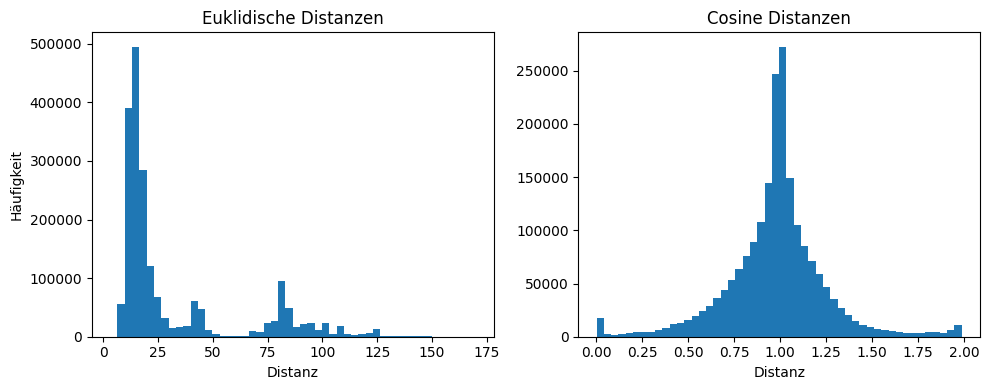

In [20]:
from sklearn.metrics import pairwise_distances

# Stichprobe (vollständige Matrizen sind oft zu groß)
rng = np.random.default_rng(0)
idx = rng.choice(len(X_scaled), size=min(2000, len(X_scaled)), replace=False)
X_sub = X_scaled[idx]

# Paarweise Distanzen
D_euclid = pairwise_distances(X_sub, metric="euclidean")
D_cosine = pairwise_distances(X_sub, metric="cosine")

# Nur obere Dreiecksmatrix (ohne Diagonale)
def upper_tri_values(D):
    return D[np.triu_indices_from(D, k=1)]

e_vals = upper_tri_values(D_euclid)
c_vals = upper_tri_values(D_cosine)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(e_vals, bins=50)
plt.title("Euklidische Distanzen")
plt.xlabel("Distanz")
plt.ylabel("Häufigkeit")

plt.subplot(1, 2, 2)
plt.hist(c_vals, bins=50)
plt.title("Cosine Distanzen")
plt.xlabel("Distanz")

plt.tight_layout()
plt.show()

Diese beiden Histogramme zeigen die Verteilung von Euklidischen Distanzen (links) und Cosine Distanzen (rechts) zwischen Datenpunkten in einem hochdimensionalen Raum.

#### Euklidische Distanzen

Die Verteilung zeigt einen starken Peak bei sehr kleinen Distanzen (nahe 0) mit extrem hohen Häufigkeiten (bis zu 500.000). Danach fällt die Häufigkeit rapide ab, mit einem kleineren sekundären Peak um Distanz 75-80. Die meisten Distanzen konzentrieren sich im Bereich 0-50, was auf viele sehr ähnliche Punktpaare hindeutet.

#### Cosine Distanzen


Diese Verteilung ist wesentlich symmetrischer und approximiert eine Normalverteilung mit Zentrum um 1.0. Die Häufigkeiten sind gleichmäßiger verteilt über den gesamten Bereich von 0 bis 2, mit dem Maximum bei etwa 270.000.

#### Interpretation

Der fundamentale Unterschied zwischen beiden Metriken wird hier deutlich: Euklidische Distanz misst die absolute räumliche Entfernung zwischen Punkten, während Cosine Distanz (1 - Cosinus-Ähnlichkeit) die Orientierung bzw. den Winkel zwischen Vektoren misst, unabhängig von deren Magnitude.
Die stark linksschiefe Verteilung der Euklidischen Distanzen deutet darauf hin, dass viele Punkte räumlich sehr nah beieinander liegen (möglicherweise Cluster oder Genre). Die normalverteilten Cosine Distanzen mit Zentrum bei 1.0 (entspricht 90° Winkel) zeigen, dass die meisten Vektorpaare weitgehend orthogonal zueinander stehen, was typisch für hochdimensionale Daten ist (curse of dimensionality)


In [21]:
def concentration_ratio(values):
    return values.min() / values.max()

print("Euklidisch (min/max):", concentration_ratio(e_vals))
print("Cosine    (min/max):", concentration_ratio(c_vals))


Euklidisch (min/max): 0.01902954348681941
Cosine    (min/max): 0.0012421601156364967


Ein höheres Verhältnis deutet darauf hin, dass alle Abstände ähnlich groß sind → geringe Trennschärfe.

### Nachbarschaftsvergleich (k-NN)

Während globale Distanzverteilungen Hinweise auf die *Curse of Dimensionality* liefern, ist für viele Anwendungsfälle – insbesondere Clustering, Similarity Search und Recommendation – die **lokale Nachbarschaftsstruktur** entscheidend.

In diesem Abschnitt wird untersucht, wie stark sich die *k*-nächsten Nachbarn eines Datenpunkts unterscheiden, wenn statt des euklidischen Abstands eine winkelbasierte Metrik (Cosine) verwendet wird.

### Methodik
Für eine Stichprobe `X_sub` werden zwei k-NN-Modelle trainiert:
- eines mit **euklidischer Distanz**
- eines mit **Cosine-Distanz**

Für jeden Datenpunkt wird anschließend die Überlappung der jeweiligen *k*-Nachbarschaften berechnet.  
Der Überlappungswert liegt im Intervall \([0, 1]\) und gibt an, welcher Anteil der Nachbarn unter beiden Metriken identisch ist.

### Interpretation
- **Hohe Überlappung**: Die Metrikwahl hat nur geringen Einfluss auf die lokale Struktur
- **Niedrige Überlappung**: Die Wahl der Distanzmetrik verändert das Nachbarschaftsverständnis deutlich

Das Histogramm visualisiert die Verteilung der Überlappungen über alle Punkte und macht sichtbar, wie stabil (oder instabil) lokale Nachbarschaften gegenüber der Metrikwahl sind.

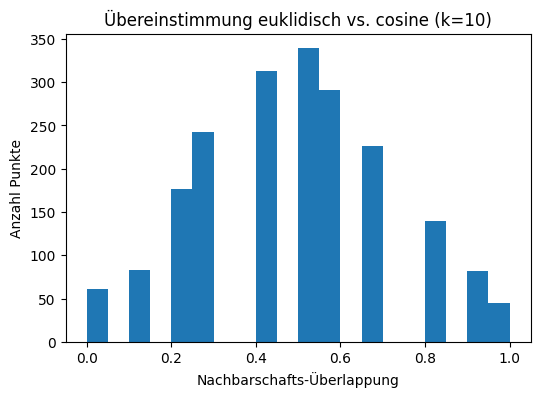

Mittlere Überlappung: 0.48745


In [22]:
from sklearn.neighbors import NearestNeighbors

k = 10

nn_e = NearestNeighbors(n_neighbors=k, metric="euclidean").fit(X_sub)
nn_c = NearestNeighbors(n_neighbors=k, metric="cosine").fit(X_sub)

nbrs_e = nn_e.kneighbors(return_distance=False)
nbrs_c = nn_c.kneighbors(return_distance=False)

# Überlappung der Nachbarn
overlaps = [
    len(set(nbrs_e[i]).intersection(nbrs_c[i])) / k
    for i in range(len(X_sub))
]

plt.figure(figsize=(6,4))
plt.hist(overlaps, bins=20)
plt.xlabel("Nachbarschafts-Überlappung")
plt.ylabel("Anzahl Punkte")
plt.title("Übereinstimmung euklidisch vs. cosine (k=10)")
plt.show()

print("Mittlere Überlappung:", np.mean(overlaps))


Dieser Graph zeigt die Übereinstimmung zwischen euklidischer und Cosine-Distanz bei einem k-Nearest-Neighbor-Ansatz (k=10).

#### Was wird dargestellt?

Für jeden Datenpunkt wurden die 10 nächsten Nachbarn einmal nach euklidischer Distanz und einmal nach Cosine-Distanz bestimmt. Die x-Achse zeigt die Nachbarschafts-Überlappung, also den Anteil der Nachbarn, die in beiden Top-10-Listen vorkommen (Jaccard-Ähnlichkeit). Die y-Achse zeigt, wie viele Punkte eine bestimmte Überlappung aufweisen.

#### Interpretation

Die Verteilung zeigt einen Peak bei etwa 0.5 (50% Überlappung) mit über 340 Punkten. Das bedeutet, dass für die meisten Datenpunkte etwa die Hälfte der 10 nächsten Nachbarn identisch sind, unabhängig davon, ob man euklidische oder Cosine-Distanz verwendet.

#### Wichtige Beobachtungen:

- Es gibt kaum Punkte mit vollständiger Übereinstimmung (1.0) - nur etwa 45 Punkte
- Auch vollständige Diskrepanz (0.0) ist selten - nur etwa 65 Punkte
- Die Mehrheit liegt im mittleren Bereich (0.3-0.6), was auf moderate Übereinstimmung hindeutet

#### Schlussfolgerung

Die beiden Distanzmetriken führen zu teilweise unterschiedlichen Nachbarschaften. Dies bestätigt die unterschiedlichen Eigenschaften: Euklidische Distanz bevorzugt räumlich nahe Punkte, während Cosine-Distanz richtungsähnliche Vektoren bevorzugt. Für Anwendungen wie Clustering oder Empfehlungssysteme kann die Wahl der Metrik daher signifikant unterschiedliche Ergebnisse liefern.

## PCA zur Visualisierung

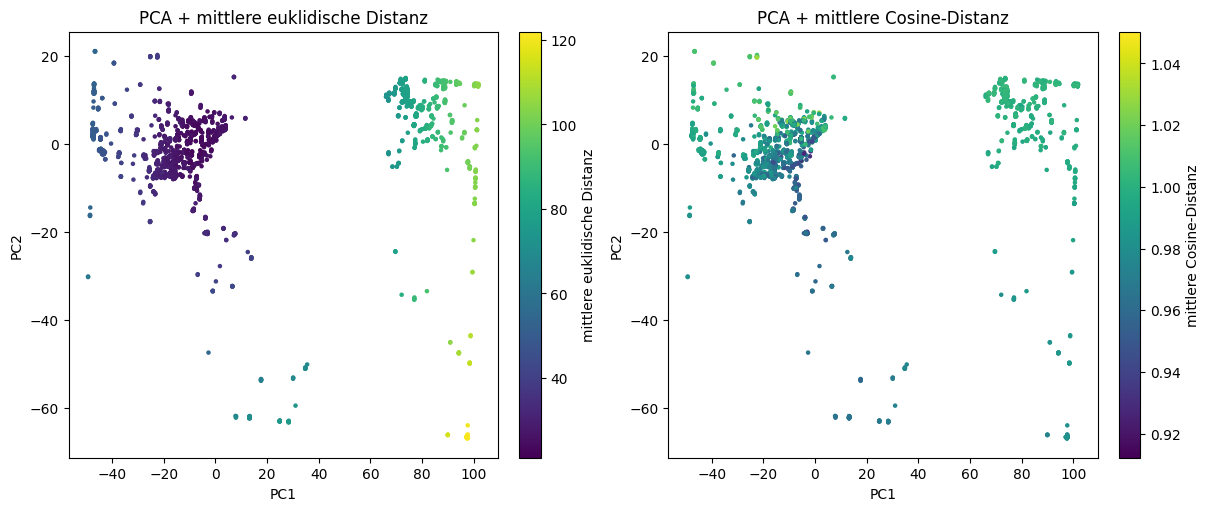

In [23]:
X_2d = PCA(n_components=2, random_state=0).fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# --- Euklidisch ---
euclid_mean = np.mean(pairwise_distances(X_scaled, metric="euclidean"), axis=1)
sc1 = axes[0].scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=euclid_mean,
    s=5
)
axes[0].set_title("PCA + mittlere euklidische Distanz")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
cb1 = fig.colorbar(sc1, ax=axes[0])
cb1.set_label("mittlere euklidische Distanz")

# --- Cosine ---
cos_mean = np.mean(pairwise_distances(X_scaled, metric="cosine"), axis=1)
sc2 = axes[1].scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=cos_mean,
    s=5
)
axes[1].set_title("PCA + mittlere Cosine-Distanz")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
cb2 = fig.colorbar(sc2, ax=axes[1])
cb2.set_label("mittlere Cosine-Distanz")

plt.show()

Diese beiden PCA-Visualisierungen zeigen die gleichen Datenpunkte im 2D-Raum der ersten beiden Hauptkomponenten (PC1 und PC2), aber farbcodiert nach unterschiedlichen Distanzmetriken zu einem zentralen Referenzpunkt oder Zentroid.

#### Struktur der Daten
 Beide Plots zeigen eine klare Clusterstruktur mit:
- Einem großen, dichten Hauptcluster im Zentrum (0|0)
- Mehreren kleinen Satelliten-Clustern oder Ausreißern die sich peripher verteilen
- Insbesondere rechts oben im Graph

#### Euklidische Distanz
Die Farbkodierung zeigt einen starken radialen Gradienten vom Zentrum nach außen:
- Dunkelviolett im Zentrum
- Grün bis gelb bei den peripheren Punkten

Dies entspricht dem erwarteten Verhalten der euklidischen Distanz - je weiter ein Punkt räumlich vom Zentrum entfernt ist, desto größer die Distanz. Der Gradient ist nahezu perfekt kreisförmig/radial.

#### Cosine-Distanz
Die Farbkodierung zeigt ein völlig anderes Muster:
- Die Werte variieren nur zwischen ≈0.91-1.05 (viel kleiner Wertebereich!)
- Es gibt keinen klaren radialen Gradienten
- Punkte mit ähnlicher Cosine-Distanz liegen oft in ähnlichen Richtungen vom Zentrum
- Die Farbverteilung folgt eher Winkelsektoren als konzentrischen Kreisen

#### Zentrale Erkenntnisse
Die Satelliten-Cluster rechts haben hohe euklidische Distanzen (gelb/grün), aber relativ moderate Cosine-Distanzen, was bedeutet, dass sie zwar räumlich weit entfernt sind, aber möglicherweise in ähnliche Richtungen vom Zentrum zeigen wie einige Punkte im Hauptcluster.

Die Cosine-Distanz ist bei unseren Feature-Vektoren also bedeutsam relevanter als die euklidische Distanz.


In [24]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix

metric = "cosine"   # <- setze hier deine gewählte Metrik: "cosine" oder "euclidean"
k = 10              # <- Nachbarschaftsgröße

# Sparse k-NN Graph: Kanten-Gewichte = Distanzen (kleiner = näher)
A = kneighbors_graph(
    X_scaled,          # oder X_sub, wenn du bewusst nur eine Stichprobe graphen willst
    n_neighbors=k,
    mode="distance",   # "distance" liefert gewichtete Kanten; alternativ "connectivity"
    metric=metric,
    include_self=False
)

# Optional: symmetrisieren (undirected graph)
# Variante 1: Vereinigung der Kanten (OR) mit minimaler Distanz, falls beide Richtungen existieren
A_sym = A.minimum(A.T) + A.maximum(A.T).multiply(A.minimum(A.T) == 0)

# Optional: in Connectivity (0/1) umwandeln
A_sym_conn = A_sym.copy()
A_sym_conn.data = np.ones_like(A_sym_conn.data)

print("Shape:", A_sym.shape)
print("Anzahl Kanten (ungerichtet, gewichtet):", A_sym.nnz)
print("Dichte:", A_sym.nnz / (A_sym.shape[0] * A_sym.shape[1]))

/Users/andreaigner/Research/thr/EAD/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3579: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Shape: (9996, 9996)
Anzahl Kanten (ungerichtet, gewichtet): 160922
Dichte: 0.0016105081488377664


## Visualisierung der Topologie des k-NN-Graphen

Ein spärlicher k-Nearest-Neighbor-Graph mit mehreren tausend Knoten lässt sich nicht sinnvoll als vollständiger Graph darstellen, da es sonst zu massivem Overplotting kommt. Stattdessen wird die Topologie des Graphen in einer **niederdimensionalen Projektion** visualisiert.

### Vorgehen
- Die hochdimensionale Feature-Matrix `X_scaled` wird mittels **PCA auf zwei Dimensionen** projiziert, um die globale Struktur der Daten abzubilden.
- Zur besseren Lesbarkeit wird eine **zufällige Stichprobe** der Knoten ausgewählt.
- Aus dem zuvor konstruierten spärlichen k-NN-Graphen wird der entsprechende **Teilgraph** extrahiert.
- Knoten werden als Punkte in der PCA-Ebene dargestellt.
- Kanten des k-NN-Graphen werden als transparente Linien eingezeichnet, sodass lokale Nachbarschaftsstrukturen sichtbar bleiben, ohne die Darstellung zu überladen.

### Ziel der Darstellung
Diese Visualisierung erlaubt eine qualitative Beurteilung,
- ob der Graph der geometrischen Struktur der Daten folgt,
- ob lokale Nachbarschaften kohärent sind,
- und ob der Graph erwartungsgemäß spärlich und lokal bleibt.

Sie dient damit als visuelle Plausibilitätsprüfung der konstruierten Topologie.


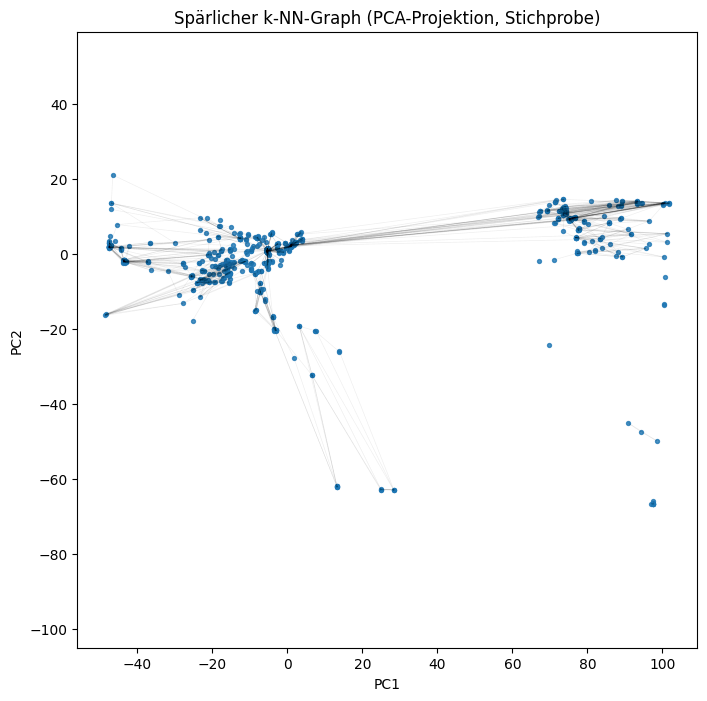

In [25]:
X_2d = PCA(n_components=2, random_state=0).fit_transform(X_scaled)

# Stichprobe für Lesbarkeit (optional, aber empfohlen)
rng = np.random.default_rng(0)
idx = rng.choice(len(X_2d), size=2000, replace=False)

A_sub = A_sym[idx][:, idx]
X_2d_sub = X_2d[idx]

plt.figure(figsize=(8, 8))

# Kanten zeichnen
rows, cols = A_sub.nonzero()
for i, j in zip(rows, cols):
    plt.plot(
        [X_2d_sub[i, 0], X_2d_sub[j, 0]],
        [X_2d_sub[i, 1], X_2d_sub[j, 1]],
        color="black",
        alpha=0.03,
        linewidth=0.5
    )

# Knoten
plt.scatter(
    X_2d_sub[:, 0],
    X_2d_sub[:, 1],
    s=8,
    alpha=0.8
)

plt.title("Spärlicher k-NN-Graph (PCA-Projektion, Stichprobe)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis("equal")
plt.show()

Dieser **Spärliche k-NN-Graph** zeigt die Nachbarschaftsbeziehungen zwischen Datenpunkten nach PCA-Projektion.

#### Struktur

- **Hauptcluster** (Zentrum): Dicht vernetzt mit vielen kurzen Verbindungen
- **Satelliten-Cluster** (rechts oben, unten): Lose angebunden mit wenigen langen Kanten
- **Ausreißer** (unten, rechts unten): Sehr schwach oder gar nicht verbunden

#### Interpretation

Die **langen, dünnen Verbindungen** von Satelliten zum Hauptcluster zeigen, dass diese Punkte strukturell isoliert sind - sie haben kaum Nachbarn in ihrer unmittelbaren Umgebung. Dies deutet auf:

- **Outliers** oder anomale Datenpunkte
- Separate **Subpopulationen** mit wenig Überlappung zum Hauptdatensatz
- Mögliche **Datenartefakte** oder seltene Klassen

Der Graph macht die **Cluster-Topologie** und potenzielle Problembereiche für Clustering-Algorithmen sofort sichtbar. Punkte mit wenigen/langen Kanten sind schwer zu klassifizieren.

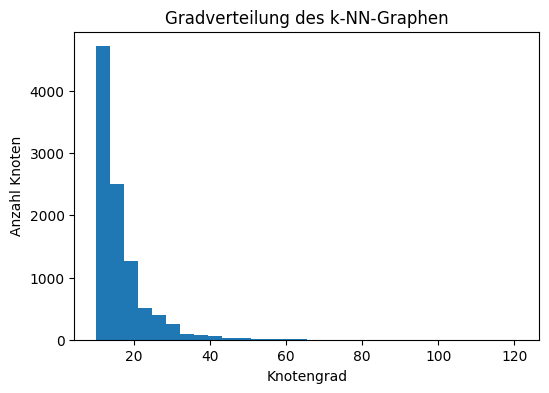

Min Grad: 10.0
Max Grad: 121.0
Ø Grad: 16.098639455782312


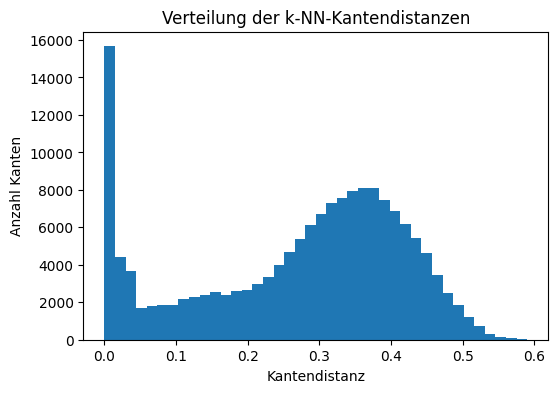

Median Distanz: 0.30832623405147186


In [26]:
degrees = np.array(A_sym_conn.sum(axis=1)).ravel()

plt.figure(figsize=(6, 4))
plt.hist(degrees, bins=30)
plt.xlabel("Knotengrad")
plt.ylabel("Anzahl Knoten")
plt.title("Gradverteilung des k-NN-Graphen")
plt.show()

print("Min Grad:", degrees.min())
print("Max Grad:", degrees.max())
print("Ø Grad:", degrees.mean())

edge_weights = A_sym.data

plt.figure(figsize=(6, 4))
plt.hist(edge_weights, bins=40)
plt.xlabel("Kantendistanz")
plt.ylabel("Anzahl Kanten")
plt.title("Verteilung der k-NN-Kantendistanzen")
plt.show()

print("Median Distanz:", np.median(edge_weights))


# Aufgabe 3: Clustering und Nyström-Approximation

# k-Means

Nach der Dimensionsreduktion (z. B. PCA) clustern wir die Songs mit **K-Means**, um ähnliche Titel anhand der extrahierten Audio-Features zu gruppieren. Die zentrale Hyperparameter-Entscheidung ist die Anzahl der Cluster **k**.

Da K-Means immer ein Ergebnis liefert (auch wenn k ungeeignet ist), bewerten wir mehrere k-Werte systematisch mit zwei etablierten Kriterien:

- **Inertia (SSE / Within-Cluster Sum of Squares):** sinkt monoton mit wachsendem k. Wir suchen einen „Knick“ (Elbow), ab dem zusätzliche Cluster nur noch wenig Verbesserung bringen.
- **Silhouette-Score:** misst, wie gut Punkte in ihrem Cluster liegen (und wie weit sie von anderen Clustern getrennt sind). Höher ist besser. Ein Maximum (oder lokales Plateau) ist oft ein guter Kandidat für k.

Im Anschluss nutzen wir einen **interaktiven Slider**, um k zwischen **10 und 150** zu wählen und darunter die resultierenden Cluster exemplarisch mit **Songtitel und Künstlername** zu inspizieren. Das ermöglicht eine schnelle qualitative Plausibilitätsprüfung (ob Cluster musikalisch/inhaltlich sinnvoll wirken).


In [27]:
X_for_cluster = X_pca if "X_pca" in globals() else X_scaled

# Sicherstellen, dass Labels-DF ausgerichtet ist
assert len(df_lab) == X_for_cluster.shape[0], "df_lab und X_for_cluster sind nicht aligned (Zeilenanzahl stimmt nicht)."

k_min, k_max = 10, 150

# Für Performance: nicht jeden k-Wert berechnen, sondern z.B. Schrittweite 5
# (Du kannst step=1 setzen, wenn es schnell genug ist.)
step = 5
ks = list(range(k_min, k_max + 1, step))

inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init="auto")
    labels = km.fit_predict(X_for_cluster)

    inertias.append(km.inertia_)
    # Silhouette ist für k>=2 definiert; hier immer true, da k>=10
    silhouettes.append(silhouette_score(X_for_cluster, labels))

best_k = ks[int(np.argmax(silhouettes))]
print(f"Bestes k nach Silhouette (auf Grid mit step={step}): {best_k}")

Bestes k nach Silhouette (auf Grid mit step=5): 10


## Elbow-Analyse

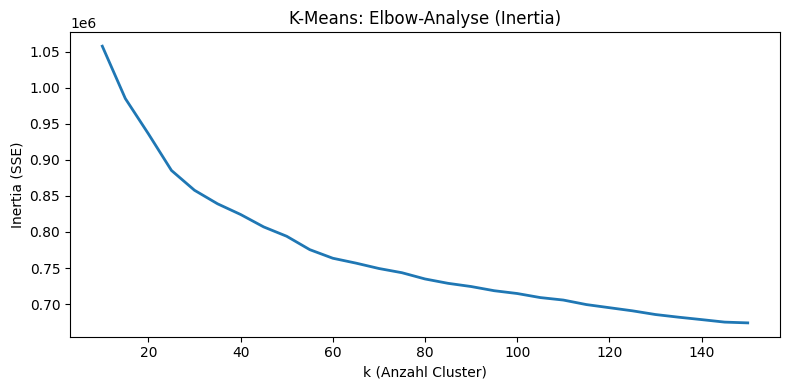

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(ks, inertias, linewidth=2)
plt.xlabel("k (Anzahl Cluster)")
plt.ylabel("Inertia (SSE)")
plt.title("K-Means: Elbow-Analyse (Inertia)")
plt.tight_layout()
plt.show()

## Silhouette-Analyse

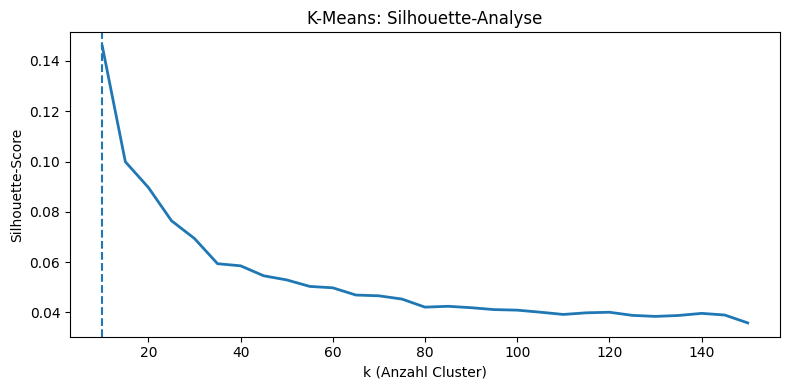

In [29]:
plt.figure(figsize=(8, 4))
plt.plot(ks, silhouettes, linewidth=2)
plt.axvline(best_k, linestyle="--")
plt.xlabel("k (Anzahl Cluster)")
plt.ylabel("Silhouette-Score")
plt.title("K-Means: Silhouette-Analyse")
plt.tight_layout()
plt.show()

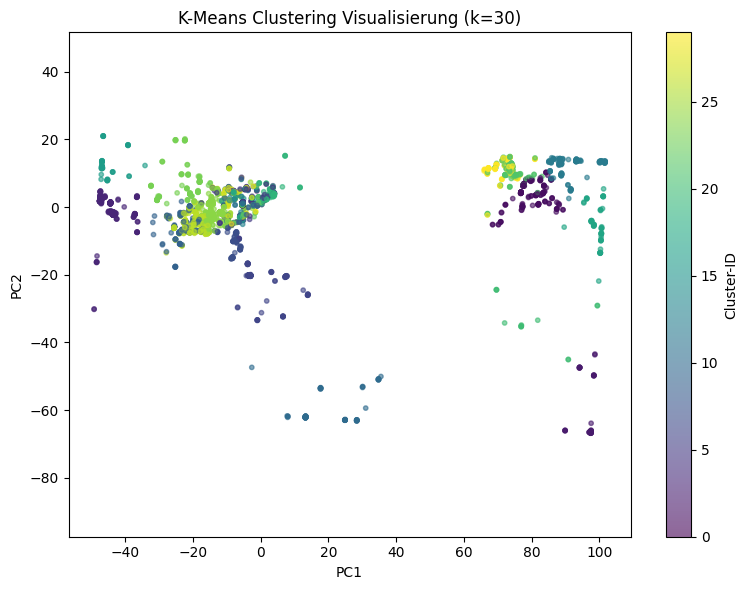

In [30]:
if "X_pca" in globals() and X_pca.shape[1] >= 2:
    X_vis = X_pca[:, :2]
else:
    from sklearn.decomposition import PCA
    X_vis = PCA(n_components=2, random_state=0).fit_transform(X_scaled)

# Cluster-Fit für das aktuelle k (vom Slider)
k = k_slider.value if "k_slider" in globals() else 30
km = KMeans(n_clusters=k, random_state=0, n_init="auto")
labels = km.fit_predict(X_for_cluster)

# Zentren in denselben 2D-Raum bringen:
# - Wenn X_for_cluster == X_pca, können wir die KMeans-Zentren direkt nehmen und auf 2D schneiden
# - Wenn X_for_cluster != X_vis, berechnen wir Zentren im Originalraum und projizieren sie über eine PCA,
#   die auf X_for_cluster fitten müsste. Für eine saubere Darstellung nutzen wir hier einen pragmatischen Ansatz:
#   Zentren werden nur geplottet, wenn die Dimensionen passen.
centers_vis = None
if X_for_cluster.shape[1] >= 2 and X_for_cluster is not X_scaled and "X_pca" in globals() and X_for_cluster is X_pca:
    centers_vis = km.cluster_centers_[:, :2]

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    X_vis[:, 0], X_vis[:, 1],
    c=labels,
    s=10,
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means Clustering Visualisierung (k={k})")
plt.axis("equal")

cb = plt.colorbar(sc)
cb.set_label("Cluster-ID")

# Optional: Cluster-Zentren (falls im selben Raum verfügbar)
if centers_vis is not None:
    plt.scatter(centers_vis[:, 0], centers_vis[:, 1], s=120, marker="x")
    # Hinweis: Keine Farbfestlegung; Marker hebt Zentren hervor.

plt.tight_layout()
plt.show()

## k-Means für verschiedene k

In [31]:
k = 130                  # <- set k here
examples_per_cluster = 8 # 5–10 recommended
max_rows_display = 1_000_000  # "extremely long" table

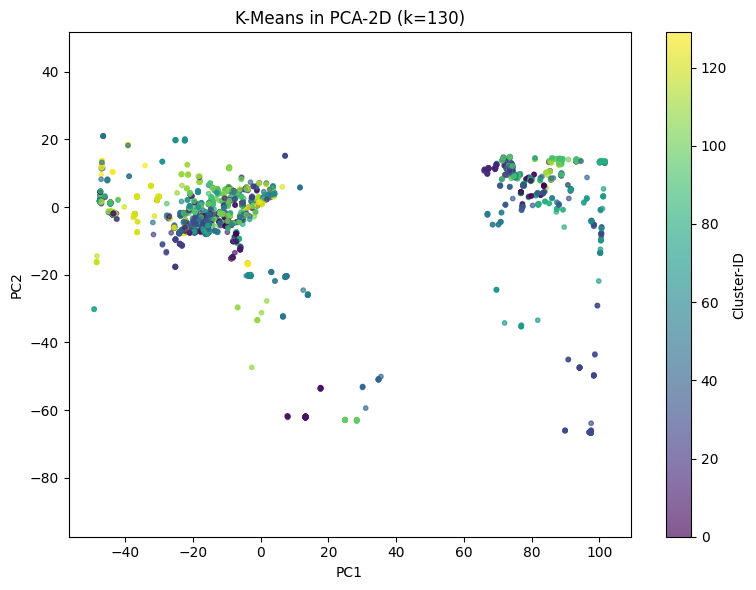

Preview table: 8 Beispiele pro Cluster — insgesamt 1021 Zeilen.


title  \
0                                                                                                               Feelin` Alone   
1                                                                                                                   baby Wayo   
2                                                                                                               Com Una Flama   
3                                                                                                          Skvoz' Tuman Vekov   
4                                                                                                         Child Of My Kingdom   
5                                                                                          Dancing With the Goddess (ttt rmx)   
6                                                                                                          Please Remember Me   
7                                                                                                                    Medicine   
8                                                                                                       Canción del Arco Iris   
9                                                                                                                 Felicidades   
10                                                                                              Sta giu' (feat. Dj Rockdrive)   
11                                                                                                                Expeditions   
12                                                                                                                      Festa   
13                                                                                                       Parabolics Studies 8   
14                                                                                                               L'Aventurier   
15                                                                                                          L'Homme De Paille   
16                                                                                                        Chicago Bound Blues   
17                                                                                                        Cold In Hands Blues   
18                                                                                                            Gin House Blues   
19                                                                                                Ain't Gonna Do That No More   
20                                                                                                      Blake's Worried Blues   
21                                                                                                      Bootleg Rum Dum Blues   
22                                                                                                      Too Tight Blues No. 2   
23                                                                                                  Big Leg Woman Gets My Pay   
24                                                                                                               Hi Ho Silver   
25                                                                                                          My Chickasay Girl   
26                                                                                                   My Heart Went That-A-Way   
27                                                                                                           Ride Ranger Ride   
28                                                                                                   The Hills Of Old Wyomin'   
29                                                                                              Strange Way To Save The World   
30                                                     The Arms That Won't Let Go (The Pillow Song)/Great Is Thy Faithful

In [32]:
assert len(df_lab) == X_for_cluster.shape[0], "df_lab and X_for_cluster must be aligned."
assert X_vis.shape[0] == X_for_cluster.shape[0], "X_vis must match number of rows."

df = df_lab.copy()
for col in ["title", "artist_name"]:
    if col not in df.columns:
        raise KeyError(f"df_lab is missing required column: {col}")
df["title"] = df["title"].fillna("").astype(str)
df["artist_name"] = df["artist_name"].fillna("").astype(str)

# ------------------------
# Fit KMeans
# ------------------------
km = KMeans(n_clusters=int(k), random_state=0, n_init="auto")
labels = km.fit_predict(X_for_cluster)

# ------------------------
# Scatter plot
# ------------------------
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, s=10, alpha=0.65)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means in PCA-2D (k={k})")
plt.axis("equal")
cb = plt.colorbar(sc)
cb.set_label("Cluster-ID")
plt.tight_layout()
plt.show()
plt.close()

# ------------------------
# Long preview table (5–10 examples per cluster)
# ------------------------
df2 = df[["title", "artist_name"]].copy()
df2["cluster"] = labels

preview = (df2.sort_values(["cluster", "artist_name", "title"])
             .groupby("cluster", as_index=False)
             .head(int(examples_per_cluster))
             .reset_index(drop=True))

pd.set_option("display.max_rows", int(max_rows_display))
pd.set_option("display.max_colwidth", 120)

print(f"Preview table: {examples_per_cluster} Beispiele pro Cluster — insgesamt {len(preview)} Zeilen.")
display(preview)

### Interpretation

bei einem hohen Wert für k können wir erkennen, dass in vielen Fällen in einem Cluster Songs des selben Artists, oder der gleichen Sprache zu finden sind. Dies gilt selbstverständlich nicht für alle Cluster, zeigt jedoch, dass die Feature Vektoren eine Dominanz in Richtung Produktionsstyl, Vocal timbre oder Instrumentenwahl aufweisen.

Da einige der Lieder auf Platformen wie Spotify nicht zu finden sind war es nur schwer möglich zu erkennen, ob bei einem geringeren Wert für k, dies zu einer Gruppierung nach Genre führt (insbesondere, da das Feld Genre im Datensatz nicht vorhanden / befüllt ist)

## Analyse der Hotttnesss-Projektion und Popularitätsstruktur

In diesem Abschnitt wird untersucht, wie sich der **song_hotttnesss-Score** über den zuvor konstruierten akustischen Merkmalsraum verteilt. Ziel ist es zu analysieren, ob bestimmte akustische Cluster systematisch mit höherer Popularität assoziiert sind oder ob sich Popularität gleichmäßig bzw. fragmentiert über den Raum verteilt.

### Fragestellung
- Gibt es **akustische Cluster**, deren Songs im Mittel eine signifikant höhere *Hotttnesss* aufweisen?
- Lassen sich Cluster identifizieren, die als **„Mainstream“-Strukturen** interpretiert werden können?
- Existieren im Gegensatz dazu **Nischen-Cluster** mit niedriger oder stark variierender Popularität?

### Methodischer Ansatz
Die Analyse erfolgt in drei Schritten:
1. **Projektion** der Songs in einen niedrigdimensionalen Raum (z. B. PCA-2D) zur visuellen Inspektion.
2. **Farbkodierung der Punkte nach song_hotttnesss**, um räumliche Muster der Popularität sichtbar zu machen.
3. **Aggregation pro Cluster**, um Unterschiede in Mittelwert, Streuung und Verteilung der Hotttnesss-Werte quantitativ zu vergleichen.

### Interpretationserwartung
- Cluster mit **hohen mittleren Hotttnesss-Werten** und geringer Varianz deuten auf standardisierte, massenkompatible Audio-Charakteristika hin (z. B. „Mainstream Pop“).
- Cluster mit **niedrigen oder stark streuenden Hotttnesss-Werten** können als Nischen-, Genre- oder Experimentierbereiche interpretiert werden.
- Eine klare Trennung spricht für eine strukturelle Kopplung zwischen akustischen Merkmalen und Popularität; eine diffuse Verteilung dagegen für eine nur schwache oder indirekte Beziehung.

Dieser Abschnitt verbindet damit die **akustische Topologie** des Feature-Raums mit einer **externen semantischen Größe (Popularität)** und erlaubt eine inhaltliche Interpretation der Cluster jenseits reiner Geometrie.


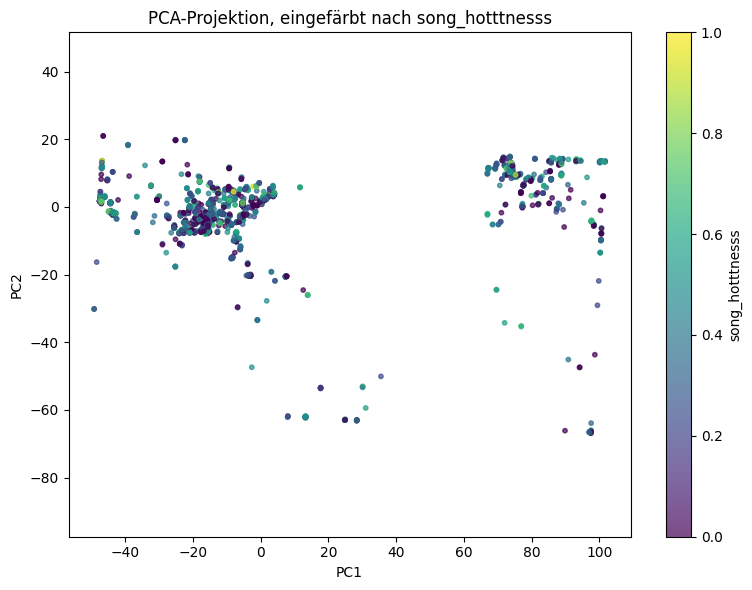

In [ ]:
assert len(df_lab) == X_scaled.shape[0], "df_lab and X_scaled must be aligned."

df = df_lab.copy()
if "song_hotttnesss" not in df.columns:
    raise KeyError("df_lab must contain column: song_hotttnesss")

# numeric + clean
df["song_hotttnesss"] = pd.to_numeric(df["song_hotttnesss"], errors="coerce")

# optional: drop rows without hotttnesss for analyses that need it
mask_h = df["song_hotttnesss"].notna().values


labels = np.asarray(labels)
assert labels.shape[0] == X_scaled.shape[0], "labels must match X_scaled rows."

df["cluster"] = labels

# PCA-2D projection (compute once)
X_2d = PCA(n_components=2, random_state=0).fit_transform(X_scaled)


plt.figure(figsize=(8, 6))

sc = plt.scatter(
    X_2d[mask_h, 0],
    X_2d[mask_h, 1],
    c=df.loc[mask_h, "song_hotttnesss"].values,
    s=10,
    alpha=0.7
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA-Projektion, eingefärbt nach song_hotttnesss")
plt.axis("equal")

cb = plt.colorbar(sc)
cb.set_label("song_hotttnesss")

plt.tight_layout()
plt.show()

### Aggregation pro Cluster: Deskriptive Popularitätsstatistiken

#### Was wird gemacht?
- Für jedes Cluster (z. B. aus KMeans) werden die Hotttnesss-Werte der zugehörigen Songs aggregiert.
- Es werden Kennzahlen wie `n`, `mean`, `median`, `std`, `min`, `max` berechnet und anschließend nach z. B. `mean` sortiert.

#### Weshalb wird das gemacht?
- Die PCA-Visualisierung ist qualitativ; die Cluster-Aggregation liefert eine **quantitative** Grundlage:
  - `mean`/`median` zeigen, ob ein Cluster im Mittel „populärer“ ist.
  - `std` zeigt, ob ein Cluster homogen ist (typisch für „Mainstream“-Strukturen) oder stark streut (typisch für gemischte/heterogene Nischen).
  - `n` ist wichtig für die Einordnung der Stabilität: kleine Cluster können starke Mittelwerte haben, aber statistisch wenig belastbar sein.
- Diese Tabelle ist die zentrale Basis, um Cluster als „Mainstream“ (hohe zentrale Tendenz, geringe Varianz) vs. „Nische“ (niedrige Werte oder hohe Varianz) zu diskutieren.

#### Interpretation (Daumenregel)
- **Mainstream-Kandidat:** hohes `mean`/`median`, moderates bis großes `n`, eher kleinere `std`
- **Nischen-Kandidat:** niedrige zentrale Tendenz oder hohe Streuung; ggf. kleine Clustergrößen


In [34]:
cluster_stats = (
    df.loc[mask_h]
      .groupby("cluster")["song_hotttnesss"]
      .agg(n="count", mean="mean", median="median", std="std", min="min", max="max")
      .sort_values("mean", ascending=False)
)

display(cluster_stats)

n      mean    median       std       min       max
cluster                                                       
13       108  0.712455  0.710663  0.116458  0.439202  1.000000
23       136  0.698727  0.686411  0.105232  0.463490  0.945995
110      135  0.634477  0.638658  0.094791  0.365144  0.896789
69         5  0.617588  0.619663  0.050027  0.563755  0.687434
12       122  0.573273  0.574157  0.129604  0.270776  0.849377
112       64  0.564435  0.591447  0.158773  0.000000  0.828088
37       121  0.544936  0.549396  0.150580  0.212045  0.972387
120       36  0.540278  0.582056  0.187714  0.000000  0.872229
61        22  0.501912  0.544523  0.225093  0.000000  0.888814
60        30  0.497503  0.565288  0.205498  0.000000  0.754274
102       46  0.494820  0.494490  0.150773  0.000000  0.823479
128       26  0.491651  0.480019  0.228991  0.000000  0.984347
96        95  0.486574  0.469873  0.148512  0.224491  0.865832
68        47  0.472914  0.485122  0.191728  0.000000  0.873619
67        76  0.467687  0.540201  0.231405  0.000000  0.849306
88        15  0.467600  0.499752  0.198647  0.000000  0.716321
117       45  0.461042  0.512254  0.186957  0.000000  0.799024
41         5  0.457583  0.454193  0.195974  0.215080  0.718485
46        71  0.457542  0.489038  0.215272  0.000000  0.909277
56        73  0.457020  0.457337  0.135532  0.212045  0.813004
101       20  0.456914  0.499730  0.214065  0.000000  0.788211
81        12  0.451488  0.509797  0.204839  0.000000  0.653816
51        73  0.451330  0.447136  0.132127  0.212045  0.756068
44        69  0.450865  0.502544  0.217906  0.000000  0.875511
80        36  0.443978  0.473347  0.186570  0.000000  0.732428
58        72  0.443024  0.434838  0.144220  0.194633  0.782453
57        63  0.437014  0.464924  0.194827  0.000000  0.818941
36        73  0.433516  0.450762  0.131484  0.212045  0.739737
42         7  0.431341  0.439202  0.103629  0.265861  0.560490
45        94  0.430873  0.427447  0.138703  0.212045  0.764420
90        68  0.427291  0.436451  0.188639  0.000000  0.756267
34        72  0.424968  0.426340  0.228531  0.000000  0.931346
38        51  0.424482  0.437036  0.162752  0.000000  0.681547
63        47  0.413273  0.383308  0.145628  0.210589  0.790345
71        16  0.408091  0.417674  0.231988  0.000000  0.705629
97        64  0.405794  0.437578  0.207051  0.000000  0.862255
43        26  0.400285  0.421133  0.223767  0.000000  0.791521
74        52  0.397828  0.393415  0.202862  0.000000  0.750701
0         44  0.391403  0.419136  0.226642  0.000000  0.747655
100       23  0.389077  0.375984  0.238845  0.000000  0.761303
19        28  0.388407  0.443395  0.233016  0.000000  0.852591
53        10  0.386637  0.366017  0.215057  0.000000  0.693150
119       76  0.383282  0.372199  0.148277  0.000000  0.721143
14        26  0.383170  0.371240  0.198742  0.000000  0.709611
17        75  0.382704  0.431654  0.216720  0.000000  0.754321
15        14  0.372924  0.340342  0.226280  0.000000  0.693001
16        77  0.371693  0.372530  0.161055  0.000000  0.696217
52        20  0.371526  0.326224  0.255478  0.000000  0.774816
127       50  0.369384  0.371653  0.224270  0.000000  0.847531
1         18  0.364753  0.431794  0.230967  0.000000  0.699914
109       19  0.362920  0.443291  0.238954  0.000000  0.775235
125       73  0.361417  0.358083  0.138499  0.000000  0.697241
105       35  0.352595  0.364612  0.186437  0.000000  0.754562
85        51  0.351088  0.305993  0.113168  0.215080  0.647247
91        54  0.349908  0.360371  0.255884  0.000000  0.997758
40        45  0.347781  0.340923  0.143532  0.000000  0.594854
108        7  0.347290  0.386477  0.177125  0.000000  0.511424
30        14  0.347255  0.381229  0.254220  0.000000  0.667506
7         25  0.344527  0.334707  0.199664  0.000000  0.639248
18        49  0.342687  0.265861  0.233996  0.000000  0.910225
114       46  0.341051  0.368951  0.209480  0.000000  0.674834
33        55  0.338666  0.367273  0.184451

### Verteilungsvergleich pro Cluster: Boxplot (Top-N Cluster)

#### Was wird gemacht?
- Für eine Auswahl der Cluster (typischerweise **Top-N nach Clustergröße**, um Lesbarkeit und Robustheit zu erhöhen) wird ein **Boxplot** der `song_hotttnesss`-Verteilungen erzeugt.
- Häufig werden Ausreißer ausgeblendet (`showfliers=False`), damit die zentrale Verteilung besser sichtbar ist.

#### Weshalb wird das gemacht?
- Mittelwerte allein können irreführend sein (z. B. durch wenige sehr populäre Ausreißer).
- Der Boxplot zeigt pro Cluster:
  - Median (robust gegenüber Ausreißern)
  - Interquartilsabstand (IQR) als Streuungsmaß
  - grobe Symmetrie/Schiefe
- Dadurch lässt sich unterscheiden, ob ein Cluster:
  - **konsistent populär** ist (enge Box, hoher Median),
  - **gemischt** ist (breite Box/Whisker),
  - oder nur durch einzelne Hits „hochgezogen“ wird.

#### Weshalb Top-N?
- Bei vielen Clustern (z. B. k=50–150) wird ein Plot über alle Cluster unlesbar.
- Top-N nach Größe priorisiert Cluster mit ausreichender Datenbasis und reduziert Zufallseffekte.


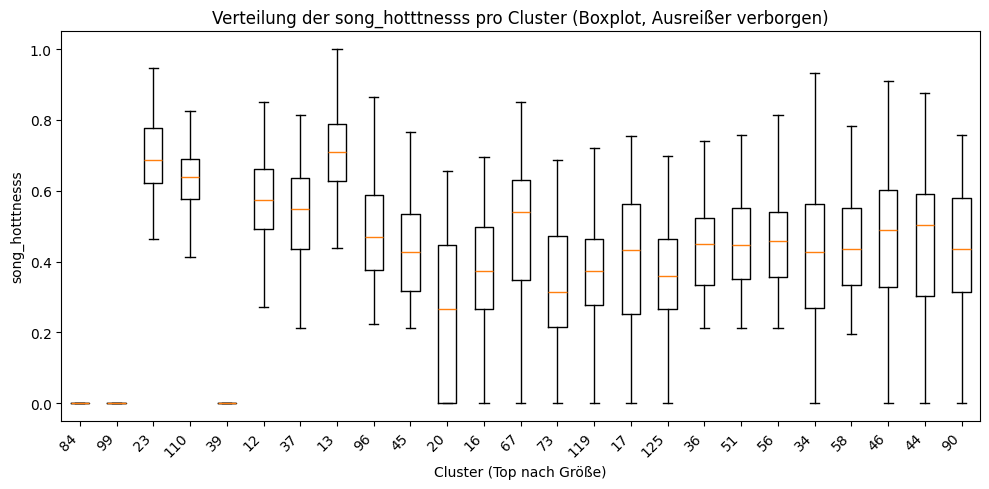

In [35]:
top_n = 25  # <-- wenn k groß ist, sonst wird es unlesbar
cluster_sizes = df.loc[mask_h].groupby("cluster")["song_hotttnesss"].size().sort_values(ascending=False)
top_clusters = cluster_sizes.head(top_n).index.tolist()

data_for_box = [
    df.loc[mask_h & (df["cluster"] == cid), "song_hotttnesss"].values
    for cid in top_clusters
]

plt.figure(figsize=(max(10, top_n * 0.4), 5))
plt.boxplot(data_for_box, showfliers=False)
plt.xticks(ticks=np.arange(1, len(top_clusters) + 1), labels=[str(c) for c in top_clusters], rotation=45, ha="right")
plt.xlabel("Cluster (Top nach Größe)")
plt.ylabel("song_hotttnesss")
plt.title("Verteilung der song_hotttnesss pro Cluster (Boxplot, Ausreißer verborgen)")
plt.tight_layout()
plt.show()

### Ranking der Cluster nach mittlerer Hotttnesss (Barplot)

#### Was wird gemacht?
- Aus den aggregierten Cluster-Statistiken wird eine Rangliste erstellt (z. B. Top 20 Cluster nach `mean`).
- Diese wird als horizontaler Balkenplot visualisiert.

#### Weshalb wird das gemacht?
- Der Plot bietet eine schnelle, kommunikative Übersicht:
  - Welche Cluster sind im Mittel am populärsten?
  - Wie groß sind die Unterschiede zwischen den Top-Clustern?
- Horizontaler Balkenplot ist bei vielen Kategorien besser lesbar als vertikale Balken (Labels).
- In Kombination mit `n` (aus der Aggregation) lässt sich vermeiden, kleine, instabile Cluster überzuinterpretieren.

#### Analytischer Nutzen
- Identifiziert Kandidaten für „Mainstream“-Cluster, die anschließend inhaltlich (z. B. über Beispiel-Songs/Artists) interpretiert werden können.
- Dient als Ausgangspunkt für tiefergehende Analysen (z. B. Genre-/Artist-Dominanz, Feature-Profile der Cluster).

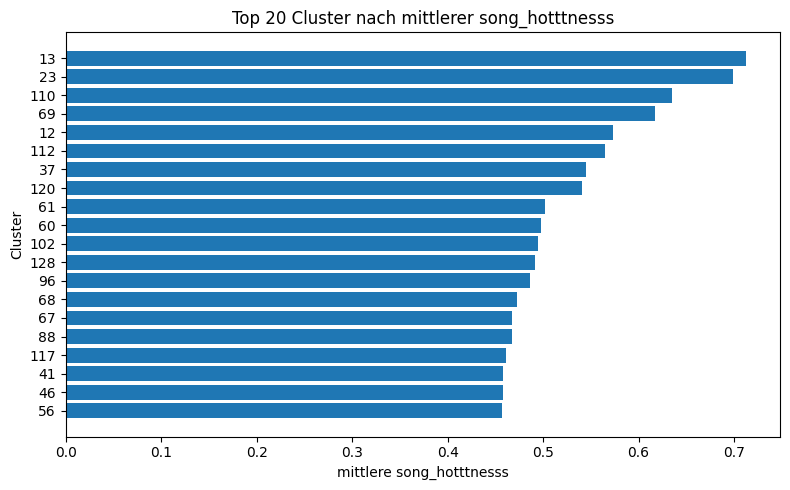

In [36]:
rank_n = 20  # <-- Top-N nach mean
rank_tbl = cluster_stats.head(rank_n).copy()

plt.figure(figsize=(8, 5))
plt.barh(rank_tbl.index.astype(str), rank_tbl["mean"].values)
plt.gca().invert_yaxis()
plt.xlabel("mittlere song_hotttnesss")
plt.ylabel("Cluster")
plt.title(f"Top {rank_n} Cluster nach mittlerer song_hotttnesss")
plt.tight_layout()
plt.show()

### Signifikanztest + Effektstärke: Kruskal–Wallis auf Hotttnesss pro Cluster

#### Was wird gemacht?
- Es wird getestet, ob sich die Verteilungen von `song_hotttnesss` **zwischen den Clustern** systematisch unterscheiden.
- Dazu wird der **Kruskal–Wallis-Test** verwendet (nichtparametrischer Test für mehrere Gruppen).
- Zusätzlich wird eine **Effektstärke** (z. B. Epsilon-Quadrat, `ε²`) berechnet, um die praktische Relevanz einzuschätzen.

#### Weshalb Kruskal–Wallis?
- `song_hotttnesss` ist häufig:
  - nicht normalverteilt,
  - schief verteilt,
  - und enthält Ausreißer.
- Kruskal–Wallis basiert auf Rängen und ist daher robuster als eine klassische ANOVA unter Verletzung von Normalitätsannahmen.

#### Was beantwortet der Test?
- Nullhypothese: Alle Cluster stammen aus derselben Verteilung (keine Unterschiede).
- Ein kleiner p-Wert deutet darauf hin, dass mindestens ein Cluster sich in der Hotttnesss-Verteilung unterscheidet.

#### Warum zusätzlich Effektstärke?
- Bei großen Stichproben kann fast alles „signifikant“ werden.
- Die Effektstärke (`ε²`) quantifiziert, **wie viel** der Variabilität durch Clusterzugehörigkeit erklärt wird:
  - kleine Werte: statistisch signifikant, aber praktisch geringe Trennschärfe
  - größere Werte: Clusterstruktur erklärt Popularität substantiell

#### Wichtige Hinweise
- Kruskal–Wallis sagt nicht, *welche* Cluster sich unterscheiden. Dafür wären Post-hoc-Tests (z. B. Dunn-Test mit Korrektur) nötig.
- Cluster mit sehr kleinem `n` sollten kritisch betrachtet oder ggf. vorab gefiltert werden, um instabile Ergebnisse zu vermeiden.


In [37]:
from scipy.stats import kruskal

groups = [
    df.loc[mask_h & (df["cluster"] == cid), "song_hotttnesss"].values
    for cid in sorted(df.loc[mask_h, "cluster"].unique())
]
# remove empty groups (shouldn't happen, but safe)
groups = [g for g in groups if len(g) > 1]

H, p = kruskal(*groups)
print(f"Kruskal-Wallis H={H:.3f}, p={p:.3e}")

# einfache Effektstärke (epsilon squared) für Kruskal-Wallis:
# eps^2 = (H - k + 1) / (n - k), k=#groups, n=#samples
k_groups = len(groups)
n_total = int(mask_h.sum())
eps2 = (H - k_groups + 1) / (n_total - k_groups) if (n_total - k_groups) > 0 else np.nan

print(f"Epsilon^2 (Effektstärke) ≈ {eps2:.4f}")

Kruskal-Wallis H=2596.521, p=0.000e+00
Epsilon^2 (Effektstärke) ≈ 0.4474


## Nyström-Verfahren: Theorie und Grundlagen

Das **Nyström-Verfahren** ist eine Methode zur effizienten Approximation großer Kernel- und Ähnlichkeitsmatrizen, wie sie typischerweise in spektralen Verfahren, Kernel-Clustering oder Graph-basierten Analysen auftreten. Ziel ist es, die hohen Speicher- und Rechenkosten zu reduzieren, die bei der expliziten Verarbeitung voll besetzter Matrizen entstehen.

### Grundidee
Gegeben sei eine symmetrische, positive semidefinite Matrix (z. B. eine Kernel- oder Ähnlichkeitsmatrix) der Größe \( n \times n \). Anstatt diese vollständig zu berechnen, wird eine **repräsentative Teilmenge von Spalten und Zeilen** (sogenannte *Landmarks*) ausgewählt. Aus dieser Teilmatrix wird anschließend eine Approximation der gesamten Matrix rekonstruiert.

Formal wird die Matrix in Blockform zerlegt:

$K \approx \begin{pmatrix} W & C^{\top} \\ C & C W^{-1} C^{\top} \end{pmatrix}$

wobei \( W \) die Kernelmatrix der Landmark-Punkte und \( C \) die Beziehungen zwischen Landmark- und Nicht-Landmark-Punkten beschreibt.

### Theoretische Grundlage
Das Verfahren basiert auf der Annahme, dass die betrachtete Matrix eine **niedrige effektive Rangstruktur** besitzt oder durch wenige dominante Eigenwerte gut approximierbar ist. Diese Annahme ist in hochdimensionalen Datenräumen – insbesondere bei Ähnlichkeits- oder Graphstrukturen – häufig erfüllt.

Durch eine Eigenwertzerlegung von \( W \) können approximierte Eigenwerte und Eigenvektoren der ursprünglichen Matrix effizient berechnet werden. Damit eignet sich das Nyström-Verfahren insbesondere für:
- spektrale Clusterverfahren,
- Graph-Laplacians,
- Kernel-PCA und verwandte Methoden.

### Motivation im vorliegenden Kontext
In der vorliegenden Analyse entstehen große, dichte Ähnlichkeitsstrukturen (z. B. Cosine-Similarity im Audio-Feature-Raum), deren explizite Berechnung und Speicherung nicht praktikabel ist. Das Nyström-Verfahren ermöglicht es, diese Strukturen **skalierbar** und **ressourcenschonend** zu approximieren, ohne die wesentlichen geometrischen und topologischen Eigenschaften des Datenraums zu verlieren.

Es stellt damit eine zentrale Brücke zwischen theoretisch fundierten spektralen Methoden und der praktischen Anwendbarkeit auf große Datensätze dar.

### Helper Funktionen für Nyström-Implementierung

In [38]:
def row_l2_normalize(X, eps=1e-12):
    nrm = np.linalg.norm(X, axis=1, keepdims=True)
    return X / np.maximum(nrm, eps)

def cosine_kernel(X, Y):
    # Cosine similarity as kernel: requires L2-normalized rows for correct cosine
    return X @ Y.T

def rbf_kernel(X, Y, gamma):
    # exp(-gamma * ||x-y||^2)
    X2 = np.sum(X*X, axis=1, keepdims=True)
    Y2 = np.sum(Y*Y, axis=1, keepdims=True).T
    sq = X2 + Y2 - 2*(X @ Y.T)
    return np.exp(-gamma * np.maximum(sq, 0.0))

def nystrom_fit(X, m=1000, n_components=50, kernel="cosine", gamma=None, seed=0, jitter=1e-8):
    """
    Returns a dict with Nyström model parameters for out-of-sample projection.
    - X: (n,d)
    - m: #landmarks
    - n_components: embedding dimension
    - kernel: "cosine" or "rbf"
    """
    rng = np.random.default_rng(seed)
    n, d = X.shape
    m = min(m, n)

    # Choose landmark indices
    idx = rng.choice(n, size=m, replace=False)
    X_L = X[idx].copy()

    # For cosine kernel, work on L2-normalized data (direction-based)
    if kernel == "cosine":
        Xn = row_l2_normalize(X)
        X_Ln = Xn[idx]
        W = cosine_kernel(X_Ln, X_Ln)
        C = cosine_kernel(Xn, X_Ln)
    elif kernel == "rbf":
        if gamma is None:
            # simple heuristic: gamma = 1 / median pairwise dist^2 on landmarks (robust-ish)
            XL = X_L
            G = XL @ XL.T
            diag = np.diag(G)
            sq = diag[:, None] + diag[None, :] - 2*G
            med = np.median(sq[np.triu_indices_from(sq, 1)])
            gamma = 1.0 / max(med, 1e-12)
        W = rbf_kernel(X_L, X_L, gamma)
        C = rbf_kernel(X, X_L, gamma)
    else:
        raise ValueError("kernel must be 'cosine' or 'rbf'")

    # Stabilize W and eigendecompose
    W = (W + W.T) / 2.0
    W = W + jitter * np.eye(m)

    evals, evecs = np.linalg.eigh(W)  # ascending
    order = np.argsort(evals)[::-1]
    evals = evals[order]
    evecs = evecs[:, order]

    # Keep top components (avoid tiny/negative due to numerical issues)
    evals = np.maximum(evals, 0.0)
    r = min(n_components, m)
    evals_r = evals[:r]
    evecs_r = evecs[:, :r]

    # Nyström embedding for training points:
    # Z = C * U * Λ^{-1/2}
    inv_sqrt = 1.0 / np.sqrt(np.maximum(evals_r, 1e-12))
    Z = (C @ evecs_r) * inv_sqrt  # broadcasting over columns

    model = {
        "kernel": kernel,
        "gamma": gamma,
        "idx_landmarks": idx,
        "X_L": X_L,
        "evals": evals_r,
        "evecs": evecs_r,
        "inv_sqrt_evals": inv_sqrt,
        # store normalized data for cosine kernel out-of-sample
        "Xn_landmarks": (X_Ln if kernel == "cosine" else None),
    }
    return Z, model

def nystrom_transform_one(x_new, model, X_all=None):
    """
    Project a single new point into existing Nyström embedding space.
    x_new: (d,)
    """
    kernel = model["kernel"]
    evecs = model["evecs"]
    inv_sqrt = model["inv_sqrt_evals"]

    if kernel == "cosine":
        # Need cosine similarity to landmarks: normalize vector
        x = x_new / max(np.linalg.norm(x_new), 1e-12)
        XLn = model["Xn_landmarks"]  # (m,d) normalized landmarks
        c = x @ XLn.T  # (m,)
    else:
        gamma = model["gamma"]
        XL = model["X_L"]            # (m,d)
        # rbf kernel vector to landmarks
        diff = XL - x_new[None, :]
        sq = np.sum(diff*diff, axis=1)  # (m,)
        c = np.exp(-gamma * np.maximum(sq, 0.0))

    # z_new = c^T U Λ^{-1/2}
    z_new = (c @ evecs) * inv_sqrt  # (r,)
    return z_new

def kmeans_numpy(Z, k=30, n_iter=50, seed=0):
    rng = np.random.default_rng(seed)
    n = Z.shape[0]
    # init centroids by random points
    centroids = Z[rng.choice(n, size=k, replace=False)].copy()

    for _ in range(n_iter):
        # distances (n,k)
        d2 = np.sum((Z[:, None, :] - centroids[None, :, :])**2, axis=2)
        labels = np.argmin(d2, axis=1)

        new_centroids = centroids.copy()
        for j in range(k):
            mask = labels == j
            if np.any(mask):
                new_centroids[j] = Z[mask].mean(axis=0)
        # convergence check
        if np.allclose(new_centroids, centroids, atol=1e-6):
            centroids = new_centroids
            break
        centroids = new_centroids

    return labels, centroids

def assign_cluster(z_new, centroids):
    d2 = np.sum((centroids - z_new[None, :])**2, axis=1)
    return int(np.argmin(d2))

def recommend(Z, z_new, top_n=20, labels=None, target_cluster=None):
    # Cosine similarity in embedding space (robust)
    ZN = Z / np.maximum(np.linalg.norm(Z, axis=1, keepdims=True), 1e-12)
    zn = z_new / max(np.linalg.norm(z_new), 1e-12)

    sims = ZN @ zn  # (n,)
    if labels is not None and target_cluster is not None:
        mask = labels == target_cluster
        cand = np.where(mask)[0]
        sims_c = sims[cand]
        order = np.argsort(sims_c)[::-1][:top_n]
        return cand[order], sims_c[order]
    else:
        order = np.argsort(sims)[::-1][:top_n]
        return order, sims[order]


In [39]:
Z, model = nystrom_fit(
    X_scaled,
    m=1200,              # landmarks
    n_components=50,     # embedding dim
    kernel="cosine",     # empfehlenswert nach deiner Metrik-Diskussion
    seed=0
)

# 2) Cluster im Embedding
k_clusters = 30
labels_Z, centroids = kmeans_numpy(Z, k=k_clusters, n_iter=60, seed=0)

# 3) Neuen Song projizieren (x_new_scaled muss vorbereitet sein)
i_new = 1234  # Index eines Songs, der NICHT in den Landmarks war
         # Rohfeatures
x_new_scaled = X_scaled[i_new]  

z_new = nystrom_transform_one(x_new_scaled, model)

# 4) Cluster-Zuordnung + Empfehlungen
cid = assign_cluster(z_new, centroids)
idx_rec, sim_rec = recommend(Z, z_new, top_n=20, labels=labels_Z, target_cluster=cid)

print("Neuer Song -> Cluster:", cid)
display(df_lab.iloc[idx_rec][["artist_name","title"]].assign(similarity=sim_rec))

Neuer Song -> Cluster: 15


artist_name  \
1234                Rihanna   
7192                Rihanna   
5330  Death From Above 1979   
1024  Death From Above 1979   
1187                 Sivuca   
487               Cómplices   
353              Bitter End   
2590        Hermeto Pascoal   
5520                Rihanna   
954                 Rihanna   
8519                Rihanna   
4571    Sivuca & Clã Brasil   
1228          Leo Gandelman   
4118                Rihanna   
2663                Rihanna   
9935                 Sivuca   
7180          Leo Gandelman   
6134                 Sivuca   
1862             Luiz Bonfa   
5589           Daddy Yankee   

                                                   title  similarity  
1234                                  Good Girl Gone Bad    1.000000  
7192                                     Breakin' Dishes    0.984830  
5330             Romantic Rights (Jesper Dahlback Remix)    0.976735  
1024                                     Romantic Rights    0.975233  
1187                                             Energia    0.974394  
487                                         Ojos Gitanos    0.972856  
353                                          Living Hell    0.971419  
2590  Little Cry For Him (Chorinho Pra Ele) (LP Version)    0.970992  
5520                                             We Ride    0.970749  
954                                 Don't Stop The Music    0.967355  
8519                                  Good Girl Gone Bad    0.965141  
4571                                    Visitando Zabelê    0.963282  
1228                                          Bari Bossa    0.961131  
4118                                                 SOS    0.960101  
2663                                    Music Of The Sun    0.959437  
9935                                        Rapaz De Bem    0.959311  
7180                                          Saxambando    0.957456  
6134                                          Copacabana    0.956350  
1862                                       Olhos Ciganos    0.951765  
5589                               Llamado De Emergencia    0.949718

## Was sagt uns diese Reccomendation über unseren Feature Vector?

Wenn wir die 2 nächsten Songs für Rihanna "Good Girl Gone Bad" betrachten erhalten wir:
- Rihanna "Breakin' Dishes"
- Death from Above 1979 "Romantic Rights (Jesper Dahlback Remix)"

Im Nachfolgenden sollen die 3 Songs im Detail analysiert werden.

In [40]:
import librosa
import librosa.display
import seaborn as sns

#### Laden der Songs als `.mp3` Datein

In [41]:
y1, sr1 = librosa.load('songs/good_girl_gone_bad.mp3')
y2, sr2 = librosa.load('songs/breakin_dishes.mp3')
y3, sr3 = librosa.load('songs/romantic_rights_remix.mp3')

#### Spektralanalyse der Songs

/var/folders/28/v917xjr11hq0b6s1cldrrhbw0000gn/T/ipykernel_12908/1787783445.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


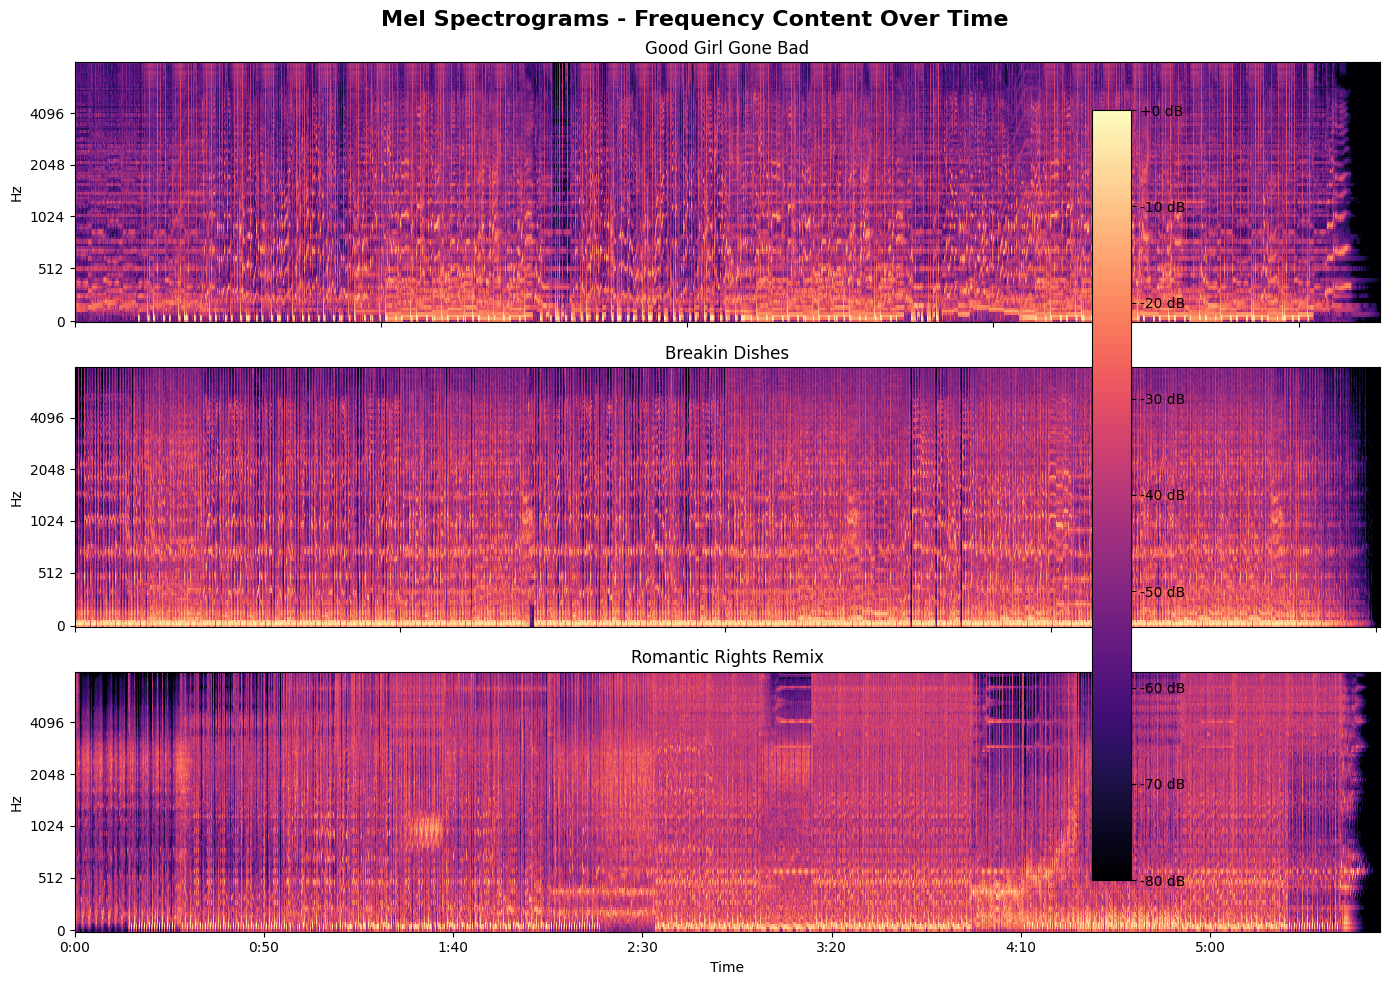

In [65]:
songs = {
    'Good Girl Gone Bad': (y1, sr1),
    'Breakin Dishes': (y2, sr2),
    'Romantic Rights Remix': (y3, sr3)
}

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Mel Spectrograms - Frequency Content Over Time', fontsize=16, fontweight='bold')

for idx, (name, (y, sr)) in enumerate(songs.items()):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=axes[idx])
    axes[idx].set_title(name, fontsize=12)
    axes[idx].label_outer()
    
fig.colorbar(img, ax=axes, format='%+2.0f dB')
plt.tight_layout()
plt.show()



/var/folders/28/v917xjr11hq0b6s1cldrrhbw0000gn/T/ipykernel_12908/1213763509.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


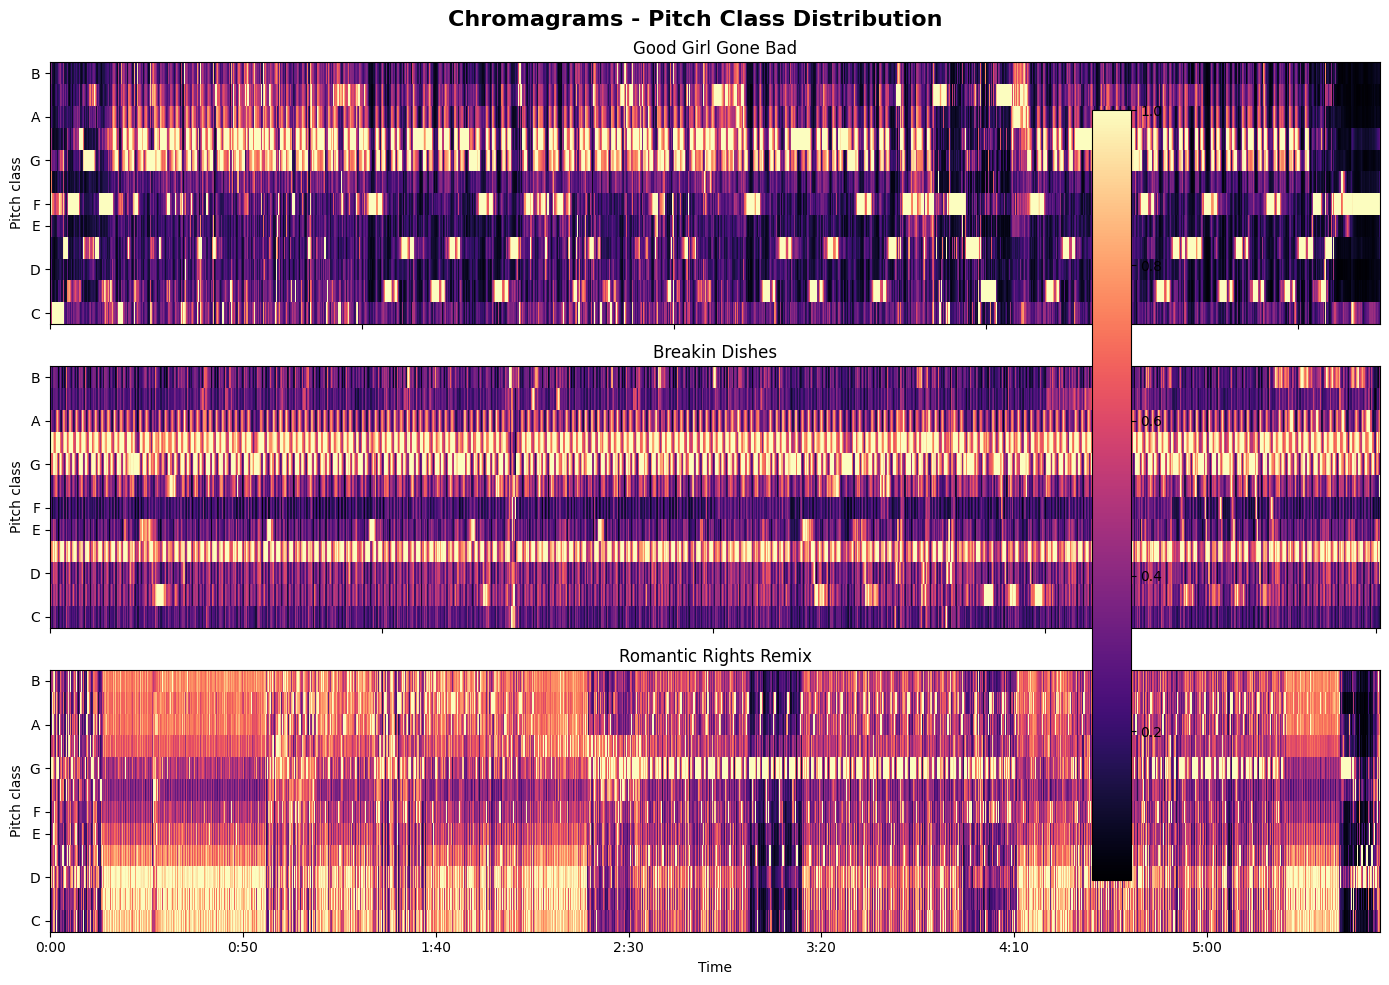

In [43]:
## 2. Chromagram - Harmonic Content

fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Chromagrams - Pitch Class Distribution', fontsize=16, fontweight='bold')

for idx, (name, (y, sr)) in enumerate(songs.items()):
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    
    img = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=axes[idx])
    axes[idx].set_title(name, fontsize=12)
    axes[idx].label_outer()
    
fig.colorbar(img, ax=axes)
plt.tight_layout()
plt.show()

#### RMS Energy Analyse, Zero-Crossing Rate und spektraler Zentroid

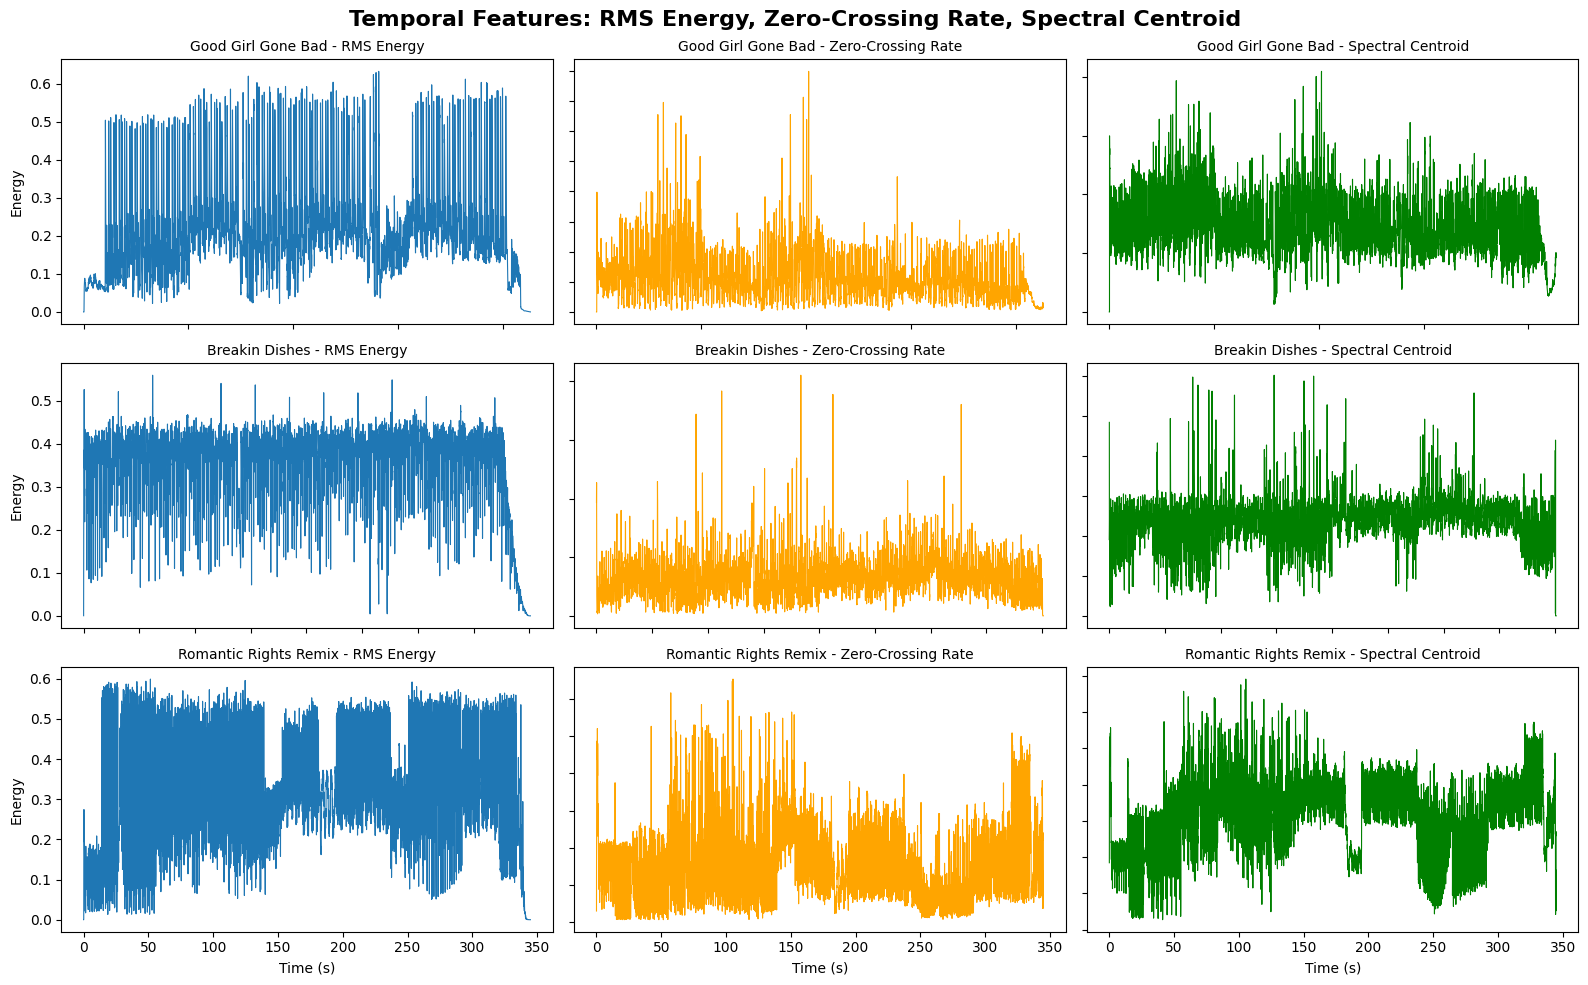

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
fig.suptitle('Temporal Features: RMS Energy, Zero-Crossing Rate, Spectral Centroid', fontsize=16, fontweight='bold')

for idx, (name, (y, sr)) in enumerate(songs.items()):
    # RMS Energy
    rms = librosa.feature.rms(y=y)[0]
    times = librosa.times_like(rms, sr=sr)
    axes[idx, 0].plot(times, rms, linewidth=0.8)
    axes[idx, 0].set_title(f'{name} - RMS Energy', fontsize=10)
    axes[idx, 0].set_ylabel('Energy')
    axes[idx, 0].label_outer()
    
    # Zero-Crossing Rate (indicates noisiness/percussiveness)
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    axes[idx, 1].plot(times, zcr, linewidth=0.8, color='orange')
    axes[idx, 1].set_title(f'{name} - Zero-Crossing Rate', fontsize=10)
    axes[idx, 1].set_ylabel('ZCR')
    axes[idx, 1].label_outer()
    
    # Spectral Centroid (brightness)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    axes[idx, 2].plot(times, cent, linewidth=0.8, color='green')
    axes[idx, 2].set_title(f'{name} - Spectral Centroid', fontsize=10)
    axes[idx, 2].set_ylabel('Hz')
    axes[idx, 2].label_outer()

for ax in axes[-1, :]:
    ax.set_xlabel('Time (s)')
    
plt.tight_layout()
plt.show()

#### Texturanalyse MFCCs

/var/folders/28/v917xjr11hq0b6s1cldrrhbw0000gn/T/ipykernel_12908/4187406148.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


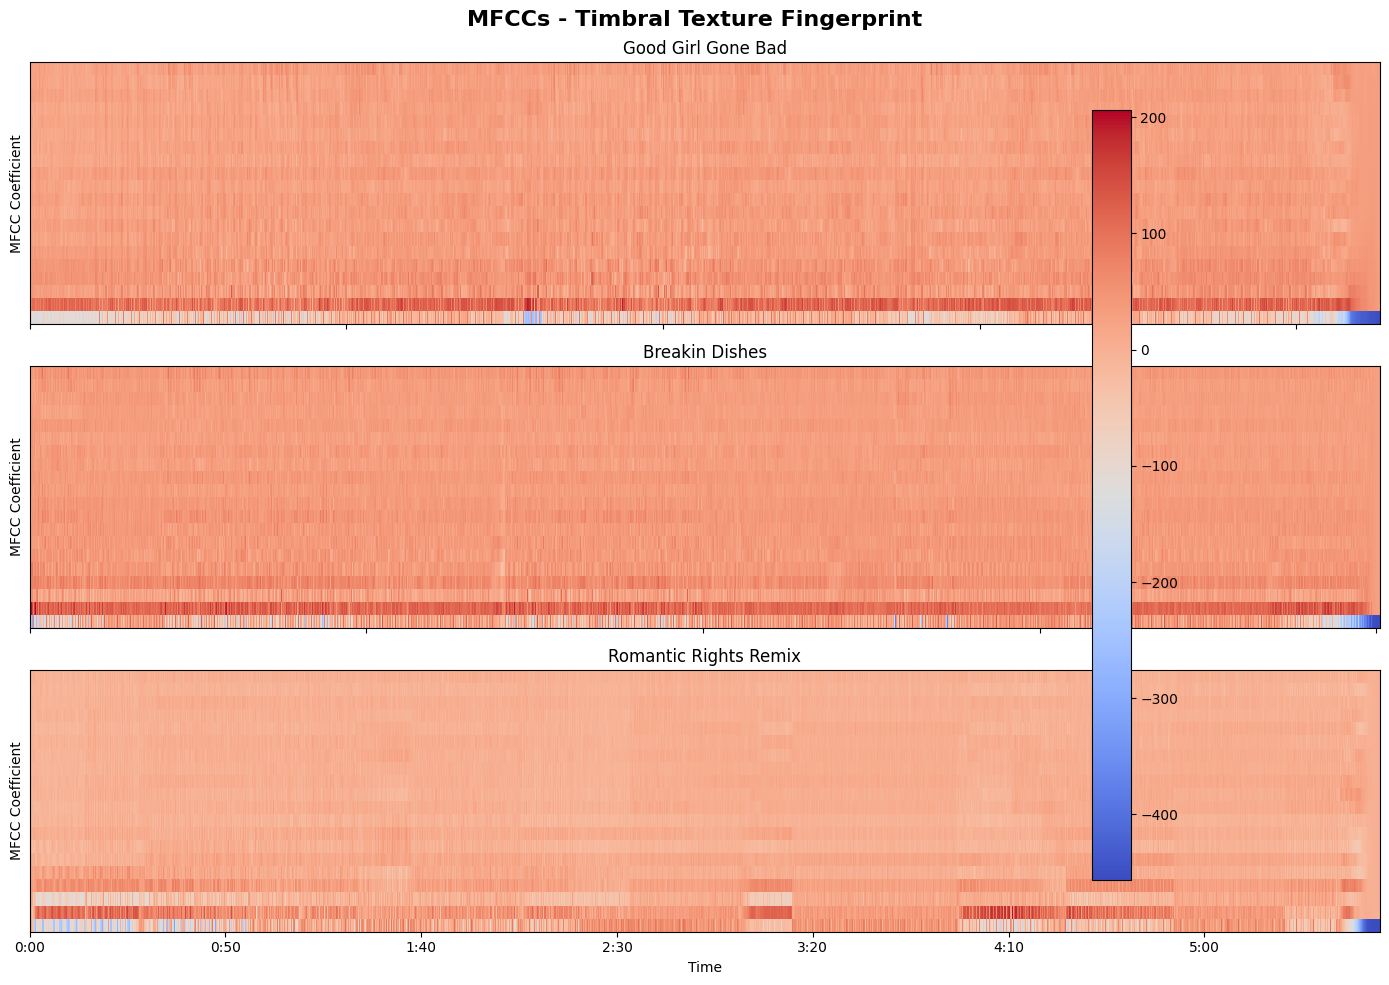

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('MFCCs - Timbral Texture Fingerprint', fontsize=16, fontweight='bold')

for idx, (name, (y, sr)) in enumerate(songs.items()):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    img = librosa.display.specshow(mfccs, x_axis='time', ax=axes[idx])
    axes[idx].set_title(name, fontsize=12)
    axes[idx].set_ylabel('MFCC Coefficient')
    axes[idx].label_outer()
    
fig.colorbar(img, ax=axes)
plt.tight_layout()
plt.show()

#### Analyse des spektralen Kontrast

/var/folders/28/v917xjr11hq0b6s1cldrrhbw0000gn/T/ipykernel_12908/139726873.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


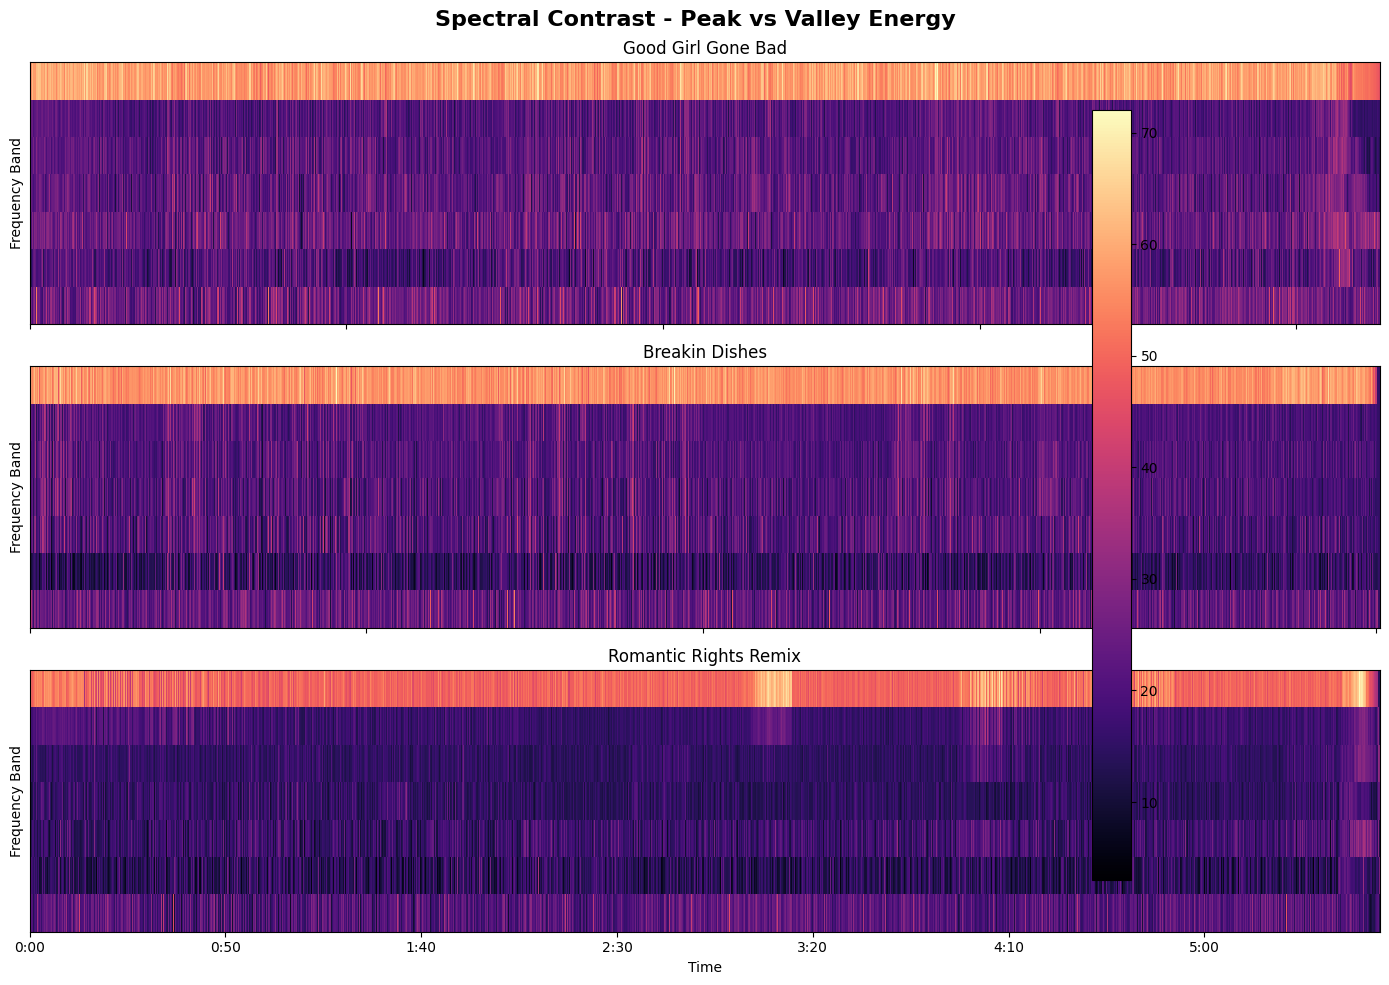

Extracting features for: Good Girl Gone Bad


/var/folders/28/v917xjr11hq0b6s1cldrrhbw0000gn/T/ipykernel_12908/139726873.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  features['tempo'] = float(tempo) if isinstance(tempo, np.ndarray) else tempo


Extracting features for: Breakin Dishes
Extracting features for: Romantic Rights Remix

FEATURE COMPARISON TABLE
                       spectral_centroid_mean  spectral_centroid_std  spectral_rolloff_mean  spectral_rolloff_std  spectral_bandwidth_mean  spectral_bandwidth_std  spectral_contrast_mean  spectral_contrast_std  mfcc_0_mean  mfcc_0_std  mfcc_1_mean  mfcc_1_std  mfcc_2_mean  mfcc_2_std  mfcc_3_mean  mfcc_3_std  mfcc_4_mean  mfcc_4_std  mfcc_5_mean  mfcc_5_std  mfcc_6_mean  mfcc_6_std  mfcc_7_mean  mfcc_7_std  mfcc_8_mean  mfcc_8_std  mfcc_9_mean  mfcc_9_std  mfcc_10_mean  mfcc_10_std  mfcc_11_mean  mfcc_11_std  mfcc_12_mean  mfcc_12_std  mfcc_13_mean  mfcc_13_std  mfcc_14_mean  mfcc_14_std  mfcc_15_mean  mfcc_15_std  mfcc_16_mean  mfcc_16_std  mfcc_17_mean  mfcc_17_std  mfcc_18_mean  mfcc_18_std  mfcc_19_mean  mfcc_19_std  chroma_mean  chroma_std  rms_mean   rms_std  zcr_mean   zcr_std       tempo
Good Girl Gone Bad                2856.847492             987.565580            

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Spectral Contrast - Peak vs Valley Energy', fontsize=16, fontweight='bold')

for idx, (name, (y, sr)) in enumerate(songs.items()):
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    img = librosa.display.specshow(contrast, x_axis='time', ax=axes[idx])
    axes[idx].set_title(name, fontsize=12)
    axes[idx].set_ylabel('Frequency Band')
    axes[idx].label_outer()
    
fig.colorbar(img, ax=axes)
plt.tight_layout()
plt.show()

## 6. Comprehensive Feature Extraction and Comparison

def extract_comprehensive_features(y, sr):
    """Extract a comprehensive feature vector from audio"""
    features = {}
    
    # Spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
    
    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features['spectral_contrast_mean'] = np.mean(contrast)
    features['spectral_contrast_std'] = np.std(contrast)
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(20):
        features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i}_std'] = np.std(mfccs[i])
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    
    # Temporal features
    rms = librosa.feature.rms(y=y)[0]
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)
    
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)
    
    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = float(tempo) if isinstance(tempo, np.ndarray) else tempo
    
    return features

# Extract features for all songs
feature_data = {}
for name, (y, sr) in songs.items():
    print(f"Extracting features for: {name}")
    feature_data[name] = extract_comprehensive_features(y, sr)



#### Feature Vergleich tabellarisch

In [64]:
# Create DataFrame
df = pd.DataFrame(feature_data).T
print("\n" + "="*80)
print("FEATURE COMPARISON TABLE")
print("="*80)
print(df.to_string())


FEATURE COMPARISON TABLE
                       spectral_centroid_mean  spectral_centroid_std  spectral_rolloff_mean  spectral_rolloff_std  spectral_bandwidth_mean  spectral_bandwidth_std  spectral_contrast_mean  spectral_contrast_std  mfcc_0_mean  mfcc_0_std  mfcc_1_mean  mfcc_1_std  mfcc_2_mean  mfcc_2_std  mfcc_3_mean  mfcc_3_std  mfcc_4_mean  mfcc_4_std  mfcc_5_mean  mfcc_5_std  mfcc_6_mean  mfcc_6_std  mfcc_7_mean  mfcc_7_std  mfcc_8_mean  mfcc_8_std  mfcc_9_mean  mfcc_9_std  mfcc_10_mean  mfcc_10_std  mfcc_11_mean  mfcc_11_std  mfcc_12_mean  mfcc_12_std  mfcc_13_mean  mfcc_13_std  mfcc_14_mean  mfcc_14_std  mfcc_15_mean  mfcc_15_std  mfcc_16_mean  mfcc_16_std  mfcc_17_mean  mfcc_17_std  mfcc_18_mean  mfcc_18_std  mfcc_19_mean  mfcc_19_std  chroma_mean  chroma_std  rms_mean   rms_std  zcr_mean   zcr_std       tempo
Good Girl Gone Bad                2856.847492             987.565580            6411.426228           1897.628211              2949.504004              441.019454     

#### Feature Korrelation

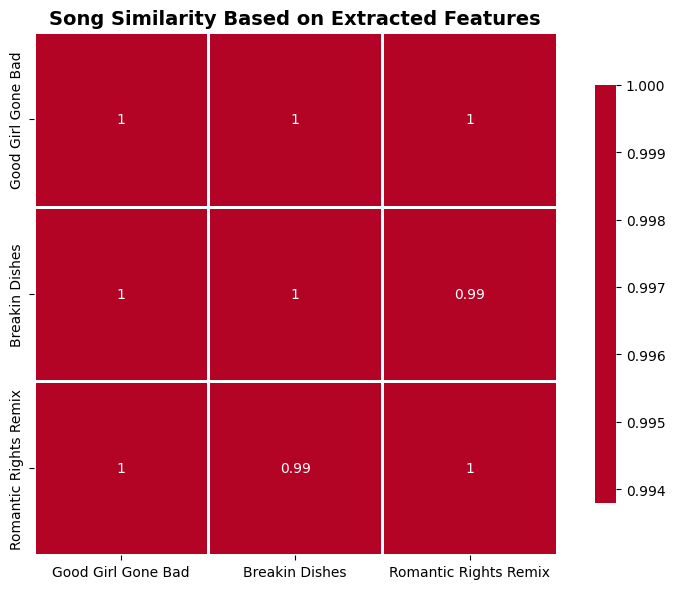

In [ ]:
correlation_matrix = df.T.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Song Similarity Based on Extracted Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### Feature Relevanz


PAIRWISE EUCLIDEAN DISTANCES (normalized features)
Breakin Dishes vs Romantic Rights Remix: 9.925
Good Girl Gone Bad vs Romantic Rights Remix: 10.586
Good Girl Gone Bad vs Breakin Dishes: 10.928


<Figure size 1200x800 with 0 Axes>

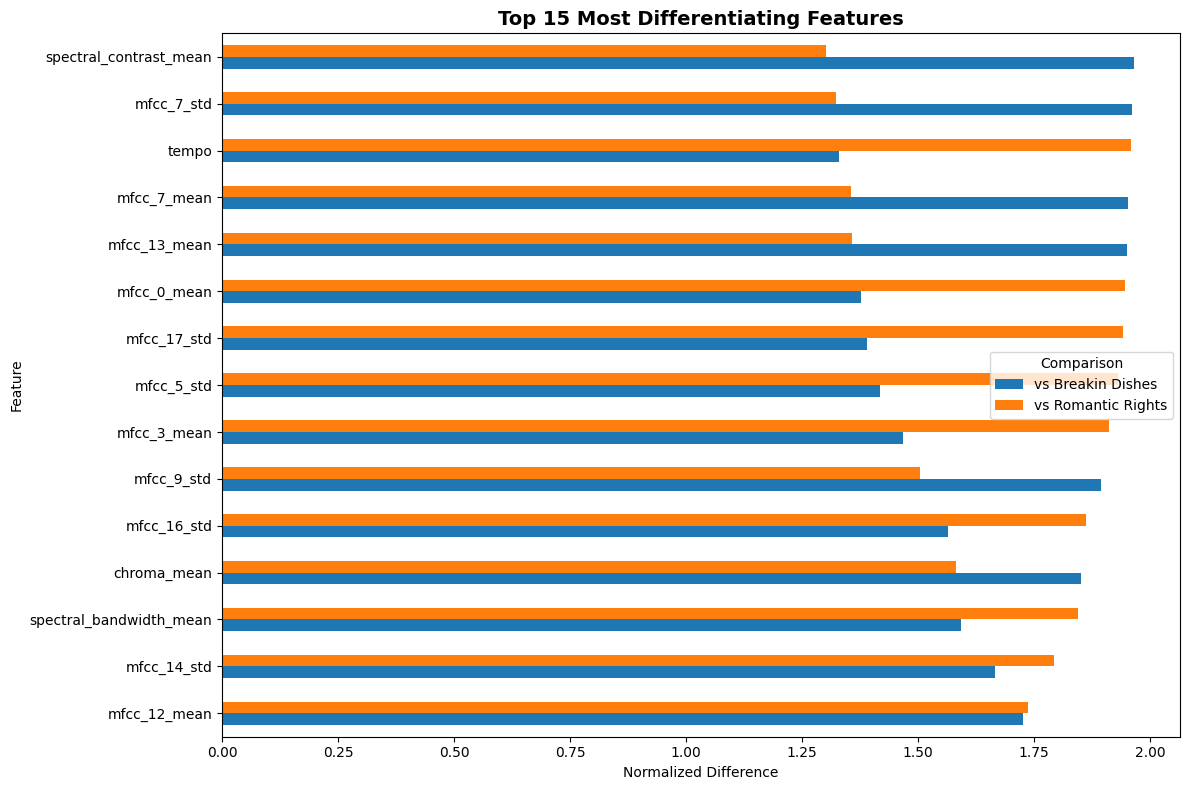

In [ ]:
df_normalized = (df - df.mean()) / df.std()

# Calculate pairwise distances
distances = {}
song_names = list(songs.keys())

for i in range(len(song_names)):
    for j in range(i+1, len(song_names)):
        pair = f"{song_names[i]} vs {song_names[j]}"
        distances[pair] = euclidean(df_normalized.iloc[i], df_normalized.iloc[j])

print("\n" + "="*80)
print("PAIRWISE EUCLIDEAN DISTANCES (normalized features)")
print("="*80)
for pair, dist in sorted(distances.items(), key=lambda x: x[1]):
    print(f"{pair}: {dist:.3f}")

# Feature contribution analysis
feature_diffs = {}
for feature in df.columns:
    # Compare Good Girl Gone Bad to the other two
    diff1 = abs(df_normalized.loc['Good Girl Gone Bad', feature] - 
                df_normalized.loc['Breakin Dishes', feature])
    diff2 = abs(df_normalized.loc['Good Girl Gone Bad', feature] - 
                df_normalized.loc['Romantic Rights Remix', feature])
    feature_diffs[feature] = {'vs_breakin': diff1, 'vs_romantic': diff2}

# Plot top differentiating features
diff_df = pd.DataFrame(feature_diffs).T
top_features = diff_df.mean(axis=1).nlargest(15)

plt.figure(figsize=(12, 8))
diff_df.loc[top_features.index].plot(kind='barh', figsize=(12, 8))
plt.title('Top 15 Most Differentiating Features', fontsize=14, fontweight='bold')
plt.xlabel('Normalized Difference')
plt.ylabel('Feature')
plt.legend(title='Comparison', labels=['vs Breakin Dishes', 'vs Romantic Rights'])
plt.tight_layout()
plt.show()

In [49]:
print("\n1. TEMPO COMPARISON:")
for name in songs.keys():
    print(f"   {name}: {df.loc[name, 'tempo']:.1f} BPM")

print("\n2. ENERGY LEVELS (RMS):")
for name in songs.keys():
    print(f"   {name}: {df.loc[name, 'rms_mean']:.4f} (mean), {df.loc[name, 'rms_std']:.4f} (std)")

print("\n3. BRIGHTNESS (Spectral Centroid):")
for name in songs.keys():
    print(f"   {name}: {df.loc[name, 'spectral_centroid_mean']:.1f} Hz")

print("\n4. NOISINESS (Zero-Crossing Rate):")
for name in songs.keys():
    print(f"   {name}: {df.loc[name, 'zcr_mean']:.4f}")

print("\n5. FEATURE CORRELATION:")
print(f"   Good Girl Gone Bad <-> Breakin Dishes: {correlation_matrix.loc['Good Girl Gone Bad', 'Breakin Dishes']:.3f}")
print(f"   Good Girl Gone Bad <-> Romantic Rights: {correlation_matrix.loc['Good Girl Gone Bad', 'Romantic Rights Remix']:.3f}")
print(f"   Breakin Dishes <-> Romantic Rights: {correlation_matrix.loc['Breakin Dishes', 'Romantic Rights Remix']:.3f}")


1. TEMPO COMPARISON:
   Good Girl Gone Bad: 95.7 BPM
   Breakin Dishes: 123.0 BPM
   Romantic Rights Remix: 136.0 BPM

2. ENERGY LEVELS (RMS):
   Good Girl Gone Bad: 0.2227 (mean), 0.1316 (std)
   Breakin Dishes: 0.3444 (mean), 0.0933 (std)
   Romantic Rights Remix: 0.2935 (mean), 0.1275 (std)

3. BRIGHTNESS (Spectral Centroid):
   Good Girl Gone Bad: 2856.8 Hz
   Breakin Dishes: 2311.3 Hz
   Romantic Rights Remix: 3141.6 Hz

4. NOISINESS (Zero-Crossing Rate):
   Good Girl Gone Bad: 0.1118
   Breakin Dishes: 0.0666
   Romantic Rights Remix: 0.1686

5. FEATURE CORRELATION:
   Good Girl Gone Bad <-> Breakin Dishes: 0.998
   Good Girl Gone Bad <-> Romantic Rights: 0.997
   Breakin Dishes <-> Romantic Rights: 0.994


### Dominanzanalyse des Feature Vektors

#### Feature Similarity Calculator
Der nachfolgende Abschnitt definiert eine Funktion, die zwei Songs featureweise vergleicht. Für jedes Audio-Feature werden absolute Differenz und prozentuale Abweichung berechnet, um Ähnlichkeit unabhängig von Skalen zu messen.

In [50]:
def analyze_feature_similarity(df, song1, song2):
    """Find which features are most similar between two songs"""
    similarities = {}
    
    for feature in df.columns:
        val1 = df.loc[song1, feature]
        val2 = df.loc[song2, feature]
        
        # Calculate percentage difference
        avg = (abs(val1) + abs(val2)) / 2
        if avg != 0:
            pct_diff = abs(val1 - val2) / avg * 100
        else:
            pct_diff = 0
        
        similarities[feature] = {
            'song1_val': val1,
            'song2_val': val2,
            'pct_diff': pct_diff,
            'abs_diff': abs(val1 - val2)
        }
    
    return similarities

#### Vergleich: *Good Girl Gone Bad* vs. *Breakin Dishes*
Wendet den Similarity-Calculator auf beide Songs an, sortiert die Features nach geringster prozentualer Abweichung und gibt die 15 ähnlichsten Features tabellarisch aus.

In [51]:
sim1 = analyze_feature_similarity(df, 'Good Girl Gone Bad', 'Breakin Dishes')
sim1_sorted = sorted(sim1.items(), key=lambda x: x[1]['pct_diff'])

In [52]:
for feature, data in sim1_sorted[:15]:
    print(f"{feature:<35} {data['song1_val']:<15.4f} {data['song2_val']:<15.4f} {data['pct_diff']:<10.2f}%")

mfcc_19_std                         10.1202         10.2484         1.26      %
mfcc_3_std                          14.6967         14.3988         2.05      %
mfcc_0_std                          82.8215         85.7810         3.51      %
spectral_contrast_std               10.5883         11.0915         4.64      %
mfcc_5_std                          12.2342         11.6675         4.74      %
mfcc_6_std                          11.2857         10.6205         6.07      %
spectral_contrast_mean              22.8885         21.3859         6.79      %
mfcc_18_std                         9.7269          9.0670          7.02      %
spectral_bandwidth_std              441.0195        409.4727        7.42      %
mfcc_13_std                         9.0295          8.3662          7.63      %
mfcc_2_std                          21.6551         19.9997         7.95      %
mfcc_4_std                          14.9206         13.7029         8.51      %
mfcc_8_std                          10.3

#### Vergleich: *Good Girl Gone Bad* vs. *Romantic Rights Remix*
Führt denselben Feature-Vergleich für das zweite Songpaar durch, um ein konsistentes Vergleichsprofil über beide Matches zu erhalten.

In [53]:
sim2 = analyze_feature_similarity(df, 'Good Girl Gone Bad', 'Romantic Rights Remix')
sim2_sorted = sorted(sim2.items(), key=lambda x: x[1]['pct_diff'])

In [54]:
for feature, data in sim2_sorted[:15]:
    print(f"{feature:<35} {data['song1_val']:<15.4f} {data['song2_val']:<15.4f} {data['pct_diff']:<10.2f}%")

spectral_rolloff_std                1897.6282       1876.9157       1.10      %
mfcc_4_std                          14.9206         15.0956         1.17      %
mfcc_9_mean                         4.6924          4.6274          1.40      %
rms_std                             0.1316          0.1275          3.13      %
mfcc_6_std                          11.2857         10.8676         3.77      %
spectral_contrast_mean              22.8885         21.8938         4.44      %
spectral_rolloff_mean               6411.4262       6092.4220       5.10      %
mfcc_15_std                         8.2367          8.7643          6.21      %
mfcc_5_std                          12.2342         11.4631         6.51      %
chroma_std                          0.3044          0.2836          7.07      %
mfcc_11_mean                        5.5202          5.9820          8.03      %
mfcc_0_std                          82.8215         89.7613         8.04      %
spectral_centroid_std               987.

#### Gemeinsame ähnliche Features (Cross-Genre-Treiber)
Identifiziert Features, die in beiden Vergleichen gleichzeitig hoch ähnlich sind. Diese Features erklären, warum das Modell Songs aus unterschiedlichen Genres zusammenclustert.


In [55]:
top_sim1 = set([f for f, _ in sim1_sorted[:20]])
top_sim2 = set([f for f, _ in sim2_sorted[:20]])
common_similar = top_sim1.intersection(top_sim2)

top_sim1
top_sim2

{'chroma_std',
 'mfcc_0_std',
 'mfcc_10_std',
 'mfcc_11_mean',
 'mfcc_11_std',
 'mfcc_15_std',
 'mfcc_1_mean',
 'mfcc_4_std',
 'mfcc_5_std',
 'mfcc_6_std',
 'mfcc_7_std',
 'mfcc_9_mean',
 'rms_std',
 'spectral_bandwidth_mean',
 'spectral_centroid_mean',
 'spectral_centroid_std',
 'spectral_contrast_mean',
 'spectral_contrast_std',
 'spectral_rolloff_mean',
 'spectral_rolloff_std'}

#### Feature-Kategorisierung
Ordnet jedes Feature semantischen Audio-Kategorien zu (z. B. Timbre, Brightness, Energy), um Interpretierbarkeit auf höherer Ebene zu ermöglichen.

In [56]:
# Categorize features
def categorize_feature(feature_name):
    if 'mfcc' in feature_name:
        return 'Timbre/Texture'
    elif 'spectral_centroid' in feature_name or 'spectral_rolloff' in feature_name:
        return 'Brightness'
    elif 'spectral_bandwidth' in feature_name:
        return 'Frequency Spread'
    elif 'spectral_contrast' in feature_name:
        return 'Texture Contrast'
    elif 'chroma' in feature_name:
        return 'Harmony'
    elif 'rms' in feature_name:
        return 'Energy/Loudness'
    elif 'zcr' in feature_name:
        return 'Noisiness'
    elif 'tempo' in feature_name:
        return 'Rhythm'
    else:
        return 'Other'

common_features_data = []
for feature in common_similar:
    avg_diff = (sim1[feature]['pct_diff'] + sim2[feature]['pct_diff']) / 2
    category = categorize_feature(feature)
    common_features_data.append((feature, avg_diff, category))

common_features_data.sort(key=lambda x: x[1])

print(f"{'Feature':<35} {'Avg % Diff':<15} {'Category':<20}")
print("-" * 80)

for feature, avg_diff, category in common_features_data[:15]:
    print(f"{feature:<35} {avg_diff:<15.2f}% {category:<20}")

Feature                             Avg % Diff      Category            
--------------------------------------------------------------------------------
mfcc_4_std                          4.84           % Timbre/Texture      
mfcc_6_std                          4.92           % Timbre/Texture      
spectral_contrast_mean              5.62           % Texture Contrast    
mfcc_5_std                          5.63           % Timbre/Texture      
mfcc_0_std                          5.78           % Timbre/Texture      
chroma_std                          9.22           % Harmony             
mfcc_10_std                         10.37          % Timbre/Texture      
spectral_contrast_std               11.19          % Texture Contrast    
spectral_bandwidth_mean             12.61          % Frequency Spread    
mfcc_11_std                         14.63          % Timbre/Texture      
mfcc_1_mean                         16.85          % Timbre/Texture      


#### Category-Level Analysis
Aggregiert Feature-Ähnlichkeiten auf Kategorieebene und berechnet durchschnittliche Similarity-Scores, um dominante akustische Einflussfaktoren zu bestimmen.

In [57]:
category_scores = {}
for feature, avg_diff, category in common_features_data:
    if category not in category_scores:
        category_scores[category] = []
    category_scores[category].append(100 - avg_diff)  # Higher score = more similar

category_summary = {}
for cat, scores in category_scores.items():
    category_summary[cat] = {
        'avg_similarity': np.mean(scores),
        'count': len(scores)
    }

print(f"{'Category':<25} {'Avg Similarity':<20} {'# Features':<15}")
print("-" * 80)
for cat, data in sorted(category_summary.items(), key=lambda x: x[1]['avg_similarity'], reverse=True):
    print(f"{cat:<25} {data['avg_similarity']:<20.2f}% {data['count']:<15}")

Category                  Avg Similarity       # Features     
--------------------------------------------------------------------------------
Texture Contrast          91.60               % 2              
Timbre/Texture            91.00               % 7              
Harmony                   90.78               % 1              
Frequency Spread          87.39               % 1              


#### Visualisierungen
Erstellt Balkendiagramme, die (a) die Wichtigkeit der Feature-Kategorien und (b) die stärksten einzelnen Features visualisieren.

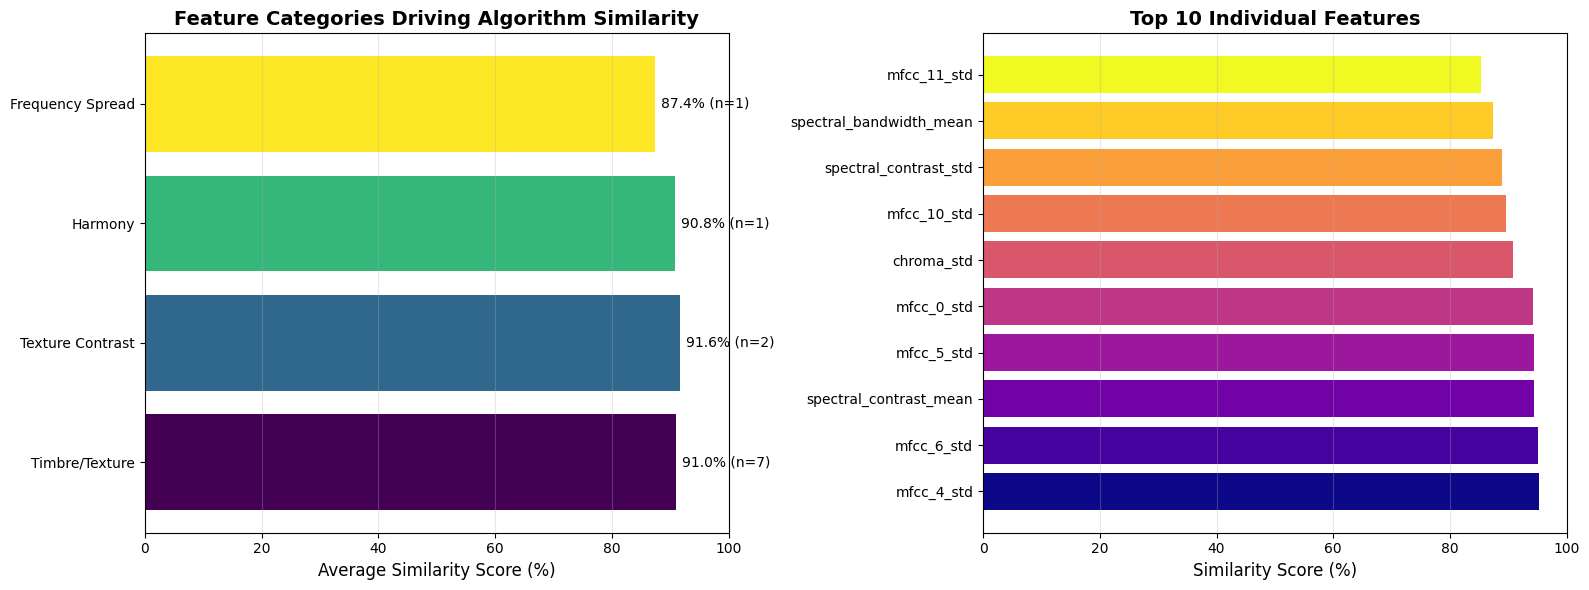

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Category importance
categories = list(category_summary.keys())
similarities = [category_summary[cat]['avg_similarity'] for cat in categories]
counts = [category_summary[cat]['count'] for cat in categories]

colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))
bars = ax1.barh(categories, similarities, color=colors)
ax1.set_xlabel('Average Similarity Score (%)', fontsize=12)
ax1.set_title('Feature Categories Driving Algorithm Similarity', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.grid(axis='x', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, counts)):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}% (n={count})', 
             va='center', fontsize=10)

# Plot 2: Top individual features
top_features_plot = common_features_data[:10]
feature_names = [f[0][:30] for f in top_features_plot]  # Truncate long names
similarity_scores = [100 - f[1] for f in top_features_plot]

colors2 = plt.cm.plasma(np.linspace(0, 1, len(feature_names)))
bars2 = ax2.barh(feature_names, similarity_scores, color=colors2)
ax2.set_xlabel('Similarity Score (%)', fontsize=12)
ax2.set_title('Top 10 Individual Features', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 100)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [59]:
all_features_categorized = {}
for feature in df.columns:
    category = categorize_feature(feature)
    if category not in all_features_categorized:
        all_features_categorized[category] = []
    
    # Calculate average difference across both comparisons
    diff1 = sim1[feature]['pct_diff']
    diff2 = sim2[feature]['pct_diff']
    avg_diff = (diff1 + diff2) / 2
    
    all_features_categorized[category].append({
        'feature': feature,
        'avg_diff': avg_diff,
        'gggb_val': df.loc['Good Girl Gone Bad', feature],
        'bd_val': df.loc['Breakin Dishes', feature],
        'rr_val': df.loc['Romantic Rights Remix', feature]
    })

#### Detaillierter Feature-Breakdown nach Kategorie
Listet für jede Kategorie die ähnlichsten Einzel-Features inklusive konkreter Feature-Werte pro Song, um mikro-akustische Unterschiede sichtbar zu machen.

In [60]:
for category in sorted(all_features_categorized.keys()):
    print(f"\n{category.upper()}")
    print("-" * 80)
    features_in_cat = sorted(all_features_categorized[category], key=lambda x: x['avg_diff'])[:5]
    
    print(f"{'Feature':<30} {'GGGB':<12} {'BD':<12} {'RR':<12} {'Avg Diff':<10}")
    print("-" * 80)
    for item in features_in_cat:
        print(f"{item['feature']:<30} {item['gggb_val']:<12.3f} {item['bd_val']:<12.3f} "
              f"{item['rr_val']:<12.3f} {item['avg_diff']:<10.2f}%")



BRIGHTNESS
--------------------------------------------------------------------------------
Feature                        GGGB         BD           RR           Avg Diff  
--------------------------------------------------------------------------------
spectral_rolloff_mean          6411.426     5163.586     6092.422     13.33     %
spectral_centroid_mean         2856.847     2311.346     3141.600     15.30     %
spectral_rolloff_std           1897.628     1362.446     1876.916     16.96     %
spectral_centroid_std          987.566      595.026      1070.814     28.85     %

ENERGY/LOUDNESS
--------------------------------------------------------------------------------
Feature                        GGGB         BD           RR           Avg Diff  
--------------------------------------------------------------------------------
rms_std                        0.132        0.093        0.128        18.57     %
rms_mean                       0.223        0.344        0.293        35.18

#### Heatmap der ähnlichsten Features
Normalisiert die 20 ähnlichsten Features über alle Songs und visualisiert sie als Heatmap, um relative Muster und Abweichungen intuitiv zu erkennen.

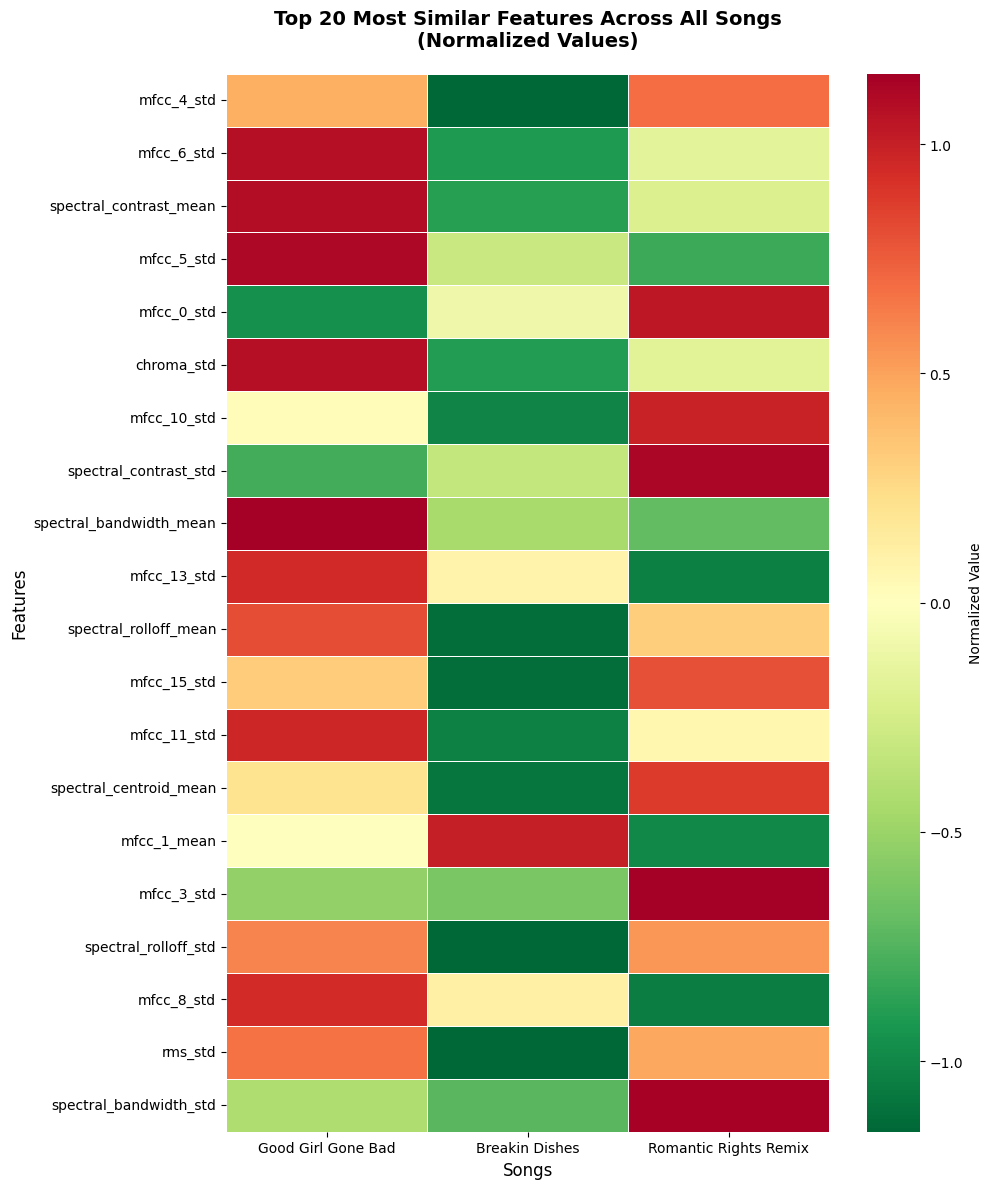

In [61]:
all_features_list = []
for feature in df.columns:
    avg_diff = (sim1[feature]['pct_diff'] + sim2[feature]['pct_diff']) / 2
    all_features_list.append((feature, avg_diff))

all_features_list.sort(key=lambda x: x[1])
top_20_features = [f[0] for f in all_features_list[:20]]

# Create heatmap data
heatmap_data = df[top_20_features].T
heatmap_data_normalized = (heatmap_data - heatmap_data.mean(axis=1).values.reshape(-1, 1)) / heatmap_data.std(axis=1).values.reshape(-1, 1)

plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_data_normalized, cmap='RdYlGn_r', center=0, 
            annot=False, fmt='.2f', linewidths=0.5, cbar_kws={'label': 'Normalized Value'})
plt.title('Top 20 Most Similar Features Across All Songs\n(Normalized Values)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Songs', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

### Auflistung der 3 wichtigsten individuellen Features

In [62]:
top_category = max(category_summary.items(), key=lambda x: x[1]['avg_similarity'])

print(f"""
SUMMARY OF FINDINGS:

1. PRIMARY SIMILARITY DRIVER:
   - Category: {top_category[0]}
   - Similarity Score: {top_category[1]['avg_similarity']:.1f}%
   - Number of Features: {top_category[1]['count']}

2. TOP 3 INDIVIDUAL FEATURES:
""")

for i, (feature, avg_diff, category) in enumerate(common_features_data[:3], 1):
    print(f"   {i}. {feature} ({category})")
    print(f"      Similarity: {100 - avg_diff:.2f}%")
    print(f"      GGGB: {df.loc['Good Girl Gone Bad', feature]:.4f}")
    print(f"      BD: {df.loc['Breakin Dishes', feature]:.4f}")
    print(f"      RR: {df.loc['Romantic Rights Remix', feature]:.4f}")
    print()

# Generate interpretation based on top categories
top_3_categories = sorted(category_summary.items(), key=lambda x: x[1]['avg_similarity'], reverse=True)[:3]
top_3_categories


SUMMARY OF FINDINGS:

1. PRIMARY SIMILARITY DRIVER:
   - Category: Texture Contrast
   - Similarity Score: 91.6%
   - Number of Features: 2

2. TOP 3 INDIVIDUAL FEATURES:

   1. mfcc_4_std (Timbre/Texture)
      Similarity: 95.16%
      GGGB: 14.9206
      BD: 13.7029
      RR: 15.0956

   2. mfcc_6_std (Timbre/Texture)
      Similarity: 95.08%
      GGGB: 11.2857
      BD: 10.6205
      RR: 10.8676

   3. spectral_contrast_mean (Texture Contrast)
      Similarity: 94.38%
      GGGB: 22.8885
      BD: 21.3859
      RR: 21.8938



[('Texture Contrast',
  {'avg_similarity': np.float64(91.59963207165558), 'count': 2}),
 ('Timbre/Texture',
  {'avg_similarity': np.float64(90.99697009514666), 'count': 7}),
 ('Harmony', {'avg_similarity': np.float64(90.78250334374968), 'count': 1})]

# Interpretation der Ergebnisse

Die Analyse zeit, dass die dominanten features (Timbre/Texture (MFCCs)) am stärksten gewichtet sind.
Dies sorgt dafür, dass die Ähnlichkeit, mit den aktuellen Featurevektoren anhand der Klangfarbe gemessen wird.
Hier wird also weniger auf ein Genre geachtet, sondern mehr auf ähnliche Klangqualität.

Diese Erkenntnisse an sich bieten einige Vorteile für die Empfehlung von Songs basierend auf dem bisherigen Lied, da durch die hohe Gewichtung der Klangfarbe ein Song mit einer ähnlichen Stimmung vorgeschlagen wird. Nach einem eher "aggressiven" Song wird erneut ein "aggresiver" Song kommen, unabhängig davon ob die Lieder vom selben Genre sind.